# DeepNoVo V2 - 


**Read Me** :  
This Notebook is an deconstruction and adaptation of the DeepNovoV2 DeepLearning program of [Tran et al.](https://arxiv.org/abs/1904.08514), by S. Chardin and S. Diebolt for the DeepLearning UE at ESPCI.
It was adapted and trainned for the use of the SMBP at ESPCI.

How to execute this program ? 
This notebook is very compute extensive and was design to run on a GPU equiped machine. Build initialy using Google Colab, it run in acceptable time with a GPU runtime provide for free by Google.

- You have to select the option in the next cell:
> - option = 'train' : Trainning Mode  
> - option = 'denovo' : Prediction of denovo spectrum mode
> - option = 'valid' : Validation of the training done previously mode
> - option = 'test' : Compare the predicted sequences (denovo) with a reference

Select the mode you want, by setting the option variable to the string presented above.  
Then set the appropriate path for the mode you selected. You can use the table of content to direct yourself to the path needed for the mode you selected.  

Then run all the cells to launch the program (Ctrl+F9).


In [0]:
option =  ['train','denovo','valid','test']  #'train' 'denovo' 'valid' 'test'
data_path = '/content/drive/My Drive/DeepNovo'

In [0]:
# Import google drive with the data to run the program
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
import torch
from torch.utils.data import Dataset
from torch import optim
import numpy as np
import pickle
import csv
import re
import sys
from dataclasses import dataclass
import torch.nn as nn
import torch.nn.functional as F
from enum import Enum
from tqdm import tqdm
import time
import math
import os

#set drive path as python directory
os.chdir(data_path)


# Table of Contents
1. [Global Variables](#globalvariables)
2. [Feature Class](#featureclass)
3. [Train Function](#train_func)
4. [Neural Networks Models](#model)
5. [Inference Model Wrapper](#inference) 
5. [Build Model](#build_func)
6. [Data Reader Function](#reader)
7. [Accecories Functions](#accesories)
> a)[Collate Function](#collate)  
b)[Extract & Move Data](#extract)  
c) [Focal Loss Function](#loss)

8. [Validation Function](#valid_func)
9. [Cython Intregration](#cython)
10. [Training Launch sequence](#train)
11. [Validation of the trainning](#valid)
12. [Denovo Part](#denovo)
> a)[Denovo File Path](#denovo_path)  
b)[Denovo Data Reader](#denovo_datareader)  
c)[Results Writer Function](#denovo_writer)  
d)[Knapsack Implementation](#knapsack)   
f)[ION CNN Denovo](#ioncnn)  
g)[Denovo Launch Sequence](#denovo_launch)
13. [Test of the prediction](#test)
>a)[Testing File path selection](#test_path)  
b)[Worker Test function](#test_worker)  
c)[Read Feature Accuracy](#test_accuracy)  
d)[Score cutoff function](#test_cutoff)  
e)[Testing Launch Sequence](#test_launch)\

## Configuration Parameters / Global Variables <a name="globalvariables"></a>
All the parameters needed and can be set-up here  
**Caution**: the batch_size parameter needs to be also set-up in the [Train Function](#train_func) due to an issue unresolved (ligne 14).

### Global Variables and Vocabulary

In [0]:
use_lstm = True #specify for taining and prediction the use of the LSTM model or not
#changing LSTM and the number of layer require a new training
#Can be retrain in addition of another training if not the same parameters

train_dir = 'train' #path to save the training parameters

#name of the training parameters saving
forward_model_save_name = 'forward_deepnovo.pth'
backward_model_save_name = 'backward_deepnovo.pth'
init_net_save_name = 'init_net.pth'

#
activation_func = F.relu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print (device)

class Direction(Enum):
    forward = 1
    backward = 2

cuda:0


In [0]:
# ==============================================================================
# GLOBAL VARIABLES for VOCABULARY
# ==============================================================================

# Special vocabulary symbols - we always put them at the start.
_PAD = "_PAD"
_GO = "_GO"
_EOS = "_EOS"
_START_VOCAB = [_PAD, _GO, _EOS]

PAD_ID = 0
GO_ID = 1
EOS_ID = 2
assert PAD_ID == 0
vocab_reverse = ['A',
                 'R',
                 'N',
                 'N(Deamidated)',
                 'D',
                 'C',
                 'C(Carboxymethyl)',
                 #~ 'C(Carbamidomethylation)',
                 'E',
                 'Q',
                 'Q(Deamidated)',
                 'G',
                 'H',
                 'I',
                 'L',
                 'K',
                 'M',
                 'M(Oxidation)',
                 'F',
                 'P',
                 'S',
                 'T',
                 'W',
                 'Y',
                 'V',
                ]

vocab_reverse = _START_VOCAB + vocab_reverse
print("vocab_reverse ", vocab_reverse)

vocab = dict([(x, y) for (y, x) in enumerate(vocab_reverse)])
print("vocab ", vocab)

vocab_size = len(vocab_reverse)
print("vocab_size ", vocab_size)


# ==============================================================================
# GLOBAL VARIABLES for THEORETICAL MASS
# ==============================================================================


mass_H = 1.0078
mass_H2O = 18.0106
mass_NH3 = 17.0265
mass_N_terminus = 1.0078
mass_C_terminus = 17.0027
mass_CO = 27.9949

mass_AA = {'_PAD': 0.0,
           '_GO': mass_N_terminus-mass_H,
           '_EOS': mass_C_terminus+mass_H,
           'A': 71.03711, # 0
           'R': 156.10111, # 1
           'N': 114.04293, # 2
           'N(Deamidated)': 115.02695,
           'D': 115.02694, # 3
           #~ 'C(Carbamidomethylation)': 103.00919, # 4
           #~ 'C(Carbamidomethylation)': 160.03065, # C(+57.02)
           'C': 103.00919,
           'C(Carboxymethyl)': 161.01919,
           #~ 'C(Carbamidomethylation)': 161.01919, # C(+58.01) # orbi
           'E': 129.04259, # 5
           'Q': 128.05858, # 6
           'Q(Deamidated)': 129.0426,
           'G': 57.02146, # 7
           'H': 137.05891, # 8
           'I': 113.08406, # 9
           'L': 113.08406, # 10
           'K': 128.09496, # 11
           'M': 131.04049, # 12
           'M(Oxidation)': 147.0354,
           'F': 147.06841, # 13
           'P': 97.05276, # 14
           'S': 87.03203, # 15
           'T': 101.04768, # 16
           'W': 186.07931, # 17
           'Y': 163.06333, # 18
           'V': 99.06841, # 19
          }

mass_ID = [mass_AA[vocab_reverse[x]] for x in range(vocab_size)]
mass_ID_np = np.array(mass_ID, dtype=np.float32)

mass_AA_min = mass_AA["G"] # 57.02146


# ==============================================================================
# GLOBAL VARIABLES for PRECISION, RESOLUTION, temp-Limits of MASS & LEN
# ==============================================================================

WINDOW_SIZE = 10 # 10 bins
print("WINDOW_SIZE ", WINDOW_SIZE)

MZ_MAX = 3000.0

MAX_NUM_PEAK = 500

KNAPSACK_AA_RESOLUTION = 10000 # 0.0001 Da
mass_AA_min_round = int(round(mass_AA_min * KNAPSACK_AA_RESOLUTION)) # 57.02146
KNAPSACK_MASS_PRECISION_TOLERANCE = 100 # 0.01 Da
num_position = 0

PRECURSOR_MASS_PRECISION_TOLERANCE = 0.01

# ONLY for accuracy evaluation

AA_MATCH_PRECISION = 0.1

# skip (x > MZ_MAX,MAX_LEN)
MAX_LEN = 30 #50 if args.search_denovo else 30
print("MAX_LEN ", MAX_LEN)


# ==============================================================================
# HYPER-PARAMETERS of the NEURAL NETWORKS
# ==============================================================================


num_ion = 12
print("num_ion ", num_ion)

weight_decay = 0.0  # no weight decay lead to better result.
print("weight_decay ", weight_decay)

#~ encoding_cnn_size = 4 * (RESOLUTION//10) # 4 # proportion to RESOLUTION
#~ encoding_cnn_filter = 4
#~ print("encoding_cnn_size ", encoding_cnn_size)
#~ print("encoding_cnn_filter ", encoding_cnn_filter)

embedding_size = 512
print("embedding_size ", embedding_size)

num_lstm_layers = 2 #2
num_units = 64
lstm_hidden_units = 512
print("num_lstm_layers ", num_lstm_layers)
print("num_units ", num_units)

dropout_rate = 0.25 #0.25

batch_size = 10 #24
num_workers = 2
print("batch_size ", batch_size)

num_epoch = 20 #20

init_lr = 1e-3

steps_per_validation = 10 #300  # 100 # 2 # 4 # 200
print("steps_per_validation ", steps_per_validation)

#Denovo Beamsearch
beam_size_param = 5 #2 #5
print("Beam size = ",beam_size_param)

# feature file column format
col_feature_id = "spec_group_id"
col_precursor_mz = "m/z"
col_precursor_charge = "z"
col_rt_mean = "rt_mean"
col_raw_sequence = "seq"
col_scan_list = "scans"
col_feature_area = "feature area"

# predicted file column format
pcol_feature_id = 0
pcol_feature_area = 1
pcol_sequence = 2
pcol_score = 3
pcol_position_score = 4
pcol_precursor_mz = 5
pcol_precursor_charge = 6
pcol_protein_id = 7
pcol_scan_list_middle = 8
pcol_scan_list_original = 9
pcol_score_max = 10

#Parameters for the Cython Module
distance_scale_factor = 100.
sinusoid_base = 30000.
spectrum_reso = 10
n_position = int(MZ_MAX) * spectrum_reso

vocab_reverse  ['_PAD', '_GO', '_EOS', 'A', 'R', 'N', 'N(Deamidated)', 'D', 'C', 'C(Carboxymethyl)', 'E', 'Q', 'Q(Deamidated)', 'G', 'H', 'I', 'L', 'K', 'M', 'M(Oxidation)', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
vocab  {'_PAD': 0, '_GO': 1, '_EOS': 2, 'A': 3, 'R': 4, 'N': 5, 'N(Deamidated)': 6, 'D': 7, 'C': 8, 'C(Carboxymethyl)': 9, 'E': 10, 'Q': 11, 'Q(Deamidated)': 12, 'G': 13, 'H': 14, 'I': 15, 'L': 16, 'K': 17, 'M': 18, 'M(Oxidation)': 19, 'F': 20, 'P': 21, 'S': 22, 'T': 23, 'W': 24, 'Y': 25, 'V': 26}
vocab_size  27
WINDOW_SIZE  10
MAX_LEN  30
num_ion  12
weight_decay  0.0
embedding_size  512
num_lstm_layers  2
num_units  64
batch_size  10
steps_per_validation  10
Beam size =  5


### Dataset paths

In [0]:
# ==============================================================================
# DATASETS Path
# ==============================================================================


knapsack_file = "knapsack_big.npy"
#topk_output = 1

input_spectrum_file_train = "Test_files/spectrum_smbp.mgf"
input_feature_file_train = "Test_files/features_smbp.csv.train"
input_spectrum_file_valid = "Test_files/spectrum_smbp.mgf"
input_feature_file_valid = "Test_files/features_smbp.csv.valid"



## Feature Class, Perplexity, ajustable learning rate <a name="featureclass"></a>
Also, Save model function

In [0]:
#------------------------------------------- Define Feature Class ------------------------------

@dataclass
class Feature:
    spec_id: str
    mz: str
    z: str
    rt_mean: str
    seq: str
    scan: str

    def to_list(self):
        """Convert the dataset to list"""
        return [self.spec_id, self.mz, self.z, self.rt_mean, self.seq, self.scan, "0.0:1.0", "1.0"]

In [0]:
def perplexity(log_loss):
    """ Compute the perplexity from the loss of the model"""
    return math.exp(log_loss) if log_loss < 300 else float('inf')


def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 3 epochs"""
    lr = init_lr * (0.1 ** ((epoch + 1) // 3))
    print(f"epoch: {epoch}\tlr: {lr}")
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


def save_model(forward_deepnovo, backward_deepnovo, init_net):
    """
    Save the model paramters for forward, backward and initalisation net, at the
    location sets in the Global variables
    """
    torch.save(forward_deepnovo.state_dict(), os.path.join(train_dir,
                                                           forward_model_save_name))
    torch.save(backward_deepnovo.state_dict(), os.path.join(train_dir,
                                                            backward_model_save_name))
    if use_lstm:
        torch.save(init_net.state_dict(), os.path.join(train_dir,
                                                   init_net_save_name))

## Train Function <a name="train_func"></a>

In [0]:
training_perp_tab = []
valid_perp_tab = []

def train():
    """
    Function govern the training of the model:
    Parameters = input_feature_file_train
                  input_spectrum_file_train
    """
    # Training Dataset creation
    train_set = DeepNovoTrainDataset(input_feature_file_train,
                                     input_spectrum_file_train)
    num_train_features = len(train_set)
    batch_size = 24 #specified here because error with only global variable
    steps_per_epoch = int(num_train_features / batch_size)
    print(steps_per_epoch,'steps per epoch')
    train_data_loader = torch.utils.data.DataLoader(dataset=train_set,
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    num_workers=num_workers,
                                                    collate_fn=collate_func)
    #Validation Dataset creation
    valid_set = DeepNovoTrainDataset(input_feature_file_valid,
                                     input_spectrum_file_valid)
    valid_data_loader = torch.utils.data.DataLoader(dataset=valid_set,
                                                    batch_size=batch_size,
                                                    shuffle=False,
                                                    num_workers=num_workers,
                                                    collate_fn=collate_func)
    
    forward_deepnovo, backward_deepnovo, init_net = build_model()
    dense_params = list(forward_deepnovo.parameters()) + list(backward_deepnovo.parameters())
    dense_optimizer = optim.Adam(dense_params,
                                 lr=init_lr,
                                 weight_decay=weight_decay)
    dense_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(dense_optimizer, 'min', factor=0.5, verbose=True,
                                                                 threshold=1e-4, cooldown=10, min_lr=1e-5)

    best_valid_loss = float("inf")
    # train loop
    best_epoch = None
    best_step = None
    start_time = time.time()
    for epoch in tqdm(range(num_epoch)):
        #adjust learning rate every 3 epoch
        adjust_learning_rate(dense_optimizer, epoch)
        for i, data in enumerate(train_data_loader):
            dense_optimizer.zero_grad()
            peak_location, \
            peak_intensity, \
            spectrum_representation, \
            batch_forward_id_target, \
            batch_backward_id_target, \
            batch_forward_ion_index, \
            batch_backward_ion_index, \
            batch_forward_id_input, \
            batch_backward_id_input = extract_and_move_data(data)
            batch_size = batch_backward_id_target.size(0)

            if use_lstm:
                initial_state_tuple = init_net(spectrum_representation)
                forward_logit, _ = forward_deepnovo(batch_forward_ion_index, peak_location, peak_intensity,
                                                    batch_forward_id_input, initial_state_tuple)
                backward_logit, _ = backward_deepnovo(batch_backward_ion_index, peak_location, peak_intensity,
                                                      batch_backward_id_input, initial_state_tuple)
            else:
                forward_logit = forward_deepnovo(batch_forward_ion_index, peak_location, peak_intensity)
                backward_logit = backward_deepnovo(batch_backward_ion_index, peak_location, peak_intensity)

            forward_loss, _ = focal_loss(forward_logit, batch_forward_id_target, ignore_index=0, gamma=2.)
            backward_loss, _ = focal_loss(backward_logit, batch_backward_id_target, ignore_index=0, gamma=2.)
            total_loss = (forward_loss + backward_loss) / 2.
            # compute gradient
            total_loss.backward()
            dense_optimizer.step()
            #depending of the steps_per_validation selected, print the time it takes,
            #for the model to train, and display the loss off training and of validation
            if (i + 1) % steps_per_validation == 0:
                duration = time.time() - start_time
                step_time = duration / steps_per_validation
                loss_cpu = total_loss.item()
                # evaluation mode
                forward_deepnovo.eval()
                backward_deepnovo.eval()
                validation_loss = validation(forward_deepnovo, backward_deepnovo, init_net, valid_data_loader)
                dense_scheduler.step(validation_loss)

                #Training and validation loss are saved to display graph of evolution.
                training_perp_tab.append(perplexity(loss_cpu))
                valid_perp_tab.append(perplexity(validation_loss))

                print(f"epoch {epoch} step {i}/{steps_per_epoch}, "
                            f"train perplexity: {perplexity(loss_cpu)}\t"
                            f"validation perplexity: {perplexity(validation_loss)}\tstep time: {step_time}")

                if validation_loss < best_valid_loss:
                    best_valid_loss = validation_loss
                    print('best valid loss achieved at epoch',epoch, 'step', i)
                    best_epoch = epoch
                    best_step = i
                    # save model if achieve a new best valid loss. Careful, if the
                    #step_per_validation is to low compared to the size of the data
                    #the model may not be saved, because not evaluated during training
                    save_model(forward_deepnovo, backward_deepnovo, init_net)

                # back to train model
                forward_deepnovo.train()
                backward_deepnovo.train()

                start_time = time.time()
            # observed that most of gpu memory is unoccupied cache, so clear cache after each batch
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

    print('best model at epoch',best_epoch,'step',best_step)

## Model of the NN <a name="model"></a>
All the Neural Network models needed and used for the treatment of the data

   ### DeepNovoPointNet with LSTM

In [0]:
class DeepNovoPointNetWithLSTM(nn.Module):
    def __init__(self):
        super(DeepNovoPointNetWithLSTM, self).__init__()
        self.t_net = TNet(with_lstm=True)
        self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                      embedding_dim=embedding_size)
        self.lstm = nn.LSTM(embedding_size,
                            lstm_hidden_units,
                            num_layers=num_lstm_layers,
                            batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.output_layer = nn.Linear(num_units + lstm_hidden_units,
                                      vocab_size)

    def forward(self, location_index, peaks_location, peaks_intensity, aa_input=None, state_tuple=None):
        """

        :param location_index: [batch, T, 26, 8] long
        :param peaks_location: [batch, N] N stands for MAX_NUM_PEAK, long
        :param peaks_intensity: [batch, N], float32
        :param aa_input:[batch, T]
        :param state_tuple: (h0, c0), where each is [num_lstm_layer, batch_size, num_units] tensor
        :return:
            logits: [batch, T, 26]
        """
        assert aa_input is not None
        N = peaks_location.size(1)
        assert N == peaks_intensity.size(1)
        batch_size, T, vocab_size, num_ion = location_index.size()

        peaks_location = peaks_location.view(batch_size, 1, N, 1)
        peaks_intensity = peaks_intensity.view(batch_size, 1, N, 1)
        peaks_location = peaks_location.expand(-1, T, -1, -1)  # [batch, T, N, 1]
        peaks_location_mask = (peaks_location > 1e-5).float()
        peaks_intensity = peaks_intensity.expand(-1, T, -1, -1)  # [batch, T, N, 1]

        location_index = location_index.view(batch_size, T, 1, vocab_size * num_ion)
        location_index_mask = (location_index > 1e-5).float()

        location_exp_minus_abs_diff = torch.exp(
            -torch.abs(
                (peaks_location - location_index) * distance_scale_factor
            )
        )
        # [batch, T, N, 26*8]

        location_exp_minus_abs_diff = location_exp_minus_abs_diff * peaks_location_mask * location_index_mask

        input_feature = torch.cat((location_exp_minus_abs_diff, peaks_intensity), dim=3)
        input_feature = input_feature.view(batch_size * T, N, vocab_size * num_ion + 1)
        input_feature = input_feature.transpose(1, 2)

        ion_feature = self.t_net(input_feature).view(batch_size, T, num_units)  # attention on peaks

        # embedding
        aa_embedded = self.embedding(aa_input)
        lstm_input = aa_embedded  # [batch, T, embedding_size]
        #dropout layer
        #lstm_input = self.dropout(lstm_input)
        #dropout doesn't appear to be efficient in this configuration
        output_feature, new_state_tuple = self.lstm(lstm_input, state_tuple)
        output_feature = torch.cat((ion_feature, activation_func(output_feature)), dim=2)
        output_feature = self.dropout(output_feature)
        logit = self.output_layer(output_feature)
        return logit, new_state_tuple
  

### T-Net Module
Same model presented in the PointNet Paper

In [0]:
class TNet(nn.Module):
    """
    the T-net structure in the Point Net paper
    """
    def __init__(self, with_lstm=False):
        super(TNet, self).__init__()
        self.with_lstm = with_lstm
        self.conv1 = nn.Conv1d(vocab_size * num_ion + 1, num_units, 1)
        self.conv2 = nn.Conv1d(num_units, 2*num_units, 1)
        self.conv3 = nn.Conv1d(2*num_units, 4*num_units, 1)
        self.fc1 = nn.Linear(4*num_units, 2*num_units)
        self.fc2 = nn.Linear(2*num_units, num_units)
        if not with_lstm:
            self.output_layer = nn.Linear(num_units, vocab_size)
        self.relu = nn.ReLU()

        self.input_batch_norm = nn.BatchNorm1d(vocab_size * num_ion + 1)

        self.bn1 = nn.BatchNorm1d(num_units)
        self.bn2 = nn.BatchNorm1d(2*num_units)
        self.bn3 = nn.BatchNorm1d(4*num_units)
        self.bn4 = nn.BatchNorm1d(2*num_units)
        self.bn5 = nn.BatchNorm1d(num_units)

    def forward(self, x):
        """

        :param x: [batch * T, 26*8+1, N]
        :return:
            logit: [batch * T, 26]
        """
        x = self.input_batch_norm(x)
        x = activation_func(self.bn1(self.conv1(x)))
        x = activation_func(self.bn2(self.conv2(x)))
        x = activation_func(self.bn3(self.conv3(x)))
        x, _ = torch.max(x, dim=2)  # global max pooling
        assert x.size(1) == 4*num_units

        x = activation_func(self.bn4(self.fc1(x)))
        x = activation_func(self.bn5(self.fc2(x)))
        if not self.with_lstm:
            x = self.output_layer(x)  # [batch * T, 26]
        return x

### Initializing NN module


In [0]:
class InitNet(nn.Module):
    def __init__(self):
        super(InitNet, self).__init__()
        self.init_state_layer = nn.Linear(embedding_size, 2 * lstm_hidden_units)

    def forward(self, spectrum_representation):
        """

        :param spectrum_representation: [N, embedding_size]
        :return:
            [num_lstm_layers, batch_size, lstm_units], [num_lstm_layers, batch_size, lstm_units],
        """
        x = torch.tanh(self.init_state_layer(spectrum_representation))
        h_0, c_0 = torch.split(x, lstm_hidden_units, dim=1)
        h_0 = torch.unsqueeze(h_0, dim=0)
        h_0 = h_0.repeat(num_lstm_layers, 1, 1)
        c_0 = torch.unsqueeze(c_0, dim=0)
        c_0 = c_0.repeat(num_lstm_layers, 1, 1)
        return h_0, c_0

### DeepNovoPointNet model, without the LSTM NN module

In [0]:
class DeepNovoPointNet(nn.Module):
    def __init__(self):
        super(DeepNovoPointNet, self).__init__()
        self.t_net = TNet(with_lstm=False)
        self.distance_scale_factor = distance_scale_factor

    def forward(self, location_index, peaks_location, peaks_intensity):
        """

        :param location_index: [batch, T, 26, 8] long
        :param peaks_location: [batch, N] N stands for MAX_NUM_PEAK, long
        :param peaks_intensity: [batch, N], float32
        :return:
            logits: [batch, T, 26]
        """

        N = peaks_location.size(1)
        assert N == peaks_intensity.size(1)
        batch_size, T, vocab_size, num_ion = location_index.size()

        peaks_location = peaks_location.view(batch_size, 1, N, 1)
        peaks_intensity = peaks_intensity.view(batch_size, 1, N, 1)
        peaks_location = peaks_location.expand(-1, T, -1, -1)  # [batch, T, N, 1]
        peaks_location_mask = (peaks_location > 1e-5).float()
        peaks_intensity = peaks_intensity.expand(-1, T, -1, -1)  # [batch, T, N, 1]

        location_index = location_index.view(batch_size, T, 1, vocab_size*num_ion)
        location_index_mask = (location_index > 1e-5).float()

        location_exp_minus_abs_diff = torch.exp(
            -torch.abs(
                (peaks_location - location_index) * self.distance_scale_factor
            )
        )
        # [batch, T, N, 26*8]

        location_exp_minus_abs_diff = location_exp_minus_abs_diff * peaks_location_mask * location_index_mask

        input_feature = torch.cat((location_exp_minus_abs_diff, peaks_intensity), dim=3)
        input_feature = input_feature.view(batch_size*T, N, vocab_size*num_ion + 1)
        input_feature = input_feature.transpose(1, 2)

        result = self.t_net(input_feature).view(batch_size, T, vocab_size)
        return result


if use_lstm: #Global Variable
    DeepNovoModel = DeepNovoPointNetWithLSTM
else:
    DeepNovoModel = DeepNovoPointNet


## Inference Model Wrapper <a name="inference"></a>


In [0]:
class InferenceModelWrapper(object):
    """
    a wrapper class so that the beam search part of code is the same for both with lstm and without lstm model.
    """
    def __init__(self, forward_model: DeepNovoModel, backward_model: DeepNovoModel, init_net: InitNet=None):
        self.forward_model = forward_model
        self.backward_model = backward_model
        # make sure all models are in eval mode
        self.forward_model.eval()
        self.backward_model.eval()
        if use_lstm:
            assert init_net is not None
            self.init_net = init_net
            self.init_net.eval()

    def step(self, candidate_location, peaks_location, peaks_intensity, aa_input, state_tuple, direction):
        """
        :param state_tuple: tuple of ([num_layer, batch_size, num_unit], [num_layer, batch_size, num_unit])
        :param aa_input: [batch, 1]
        :param candidate_location: [batch, 1, 26, 8]
        :param peaks_location: [batch, N]
        :param peaks_intensity: [batch, N]
        :param direction: enum class, whether forward or backward
        :return: (log_prob, new_hidden_state)
        log_prob: the pred log prob of shape [batch, 26]
        """
        if direction == Direction.forward:
            model = self.forward_model
        else:
            model = self.backward_model

        with torch.no_grad():
            if use_lstm:
                logit, new_state_tuple = model(candidate_location, peaks_location, peaks_intensity, aa_input,
                                               state_tuple)
            else:
                logit = model(candidate_location, peaks_location, peaks_intensity)
                new_state_tuple = None
            logit = torch.squeeze(logit, dim=1)
            log_prob = F.log_softmax(logit)
        return log_prob, new_state_tuple

    def initial_hidden_state(self, spectrum_representation):
        """

        :param: spectrum_representation, [batch, embedding_size]
        :return:
            [num_lstm_layers, batch_size, lstm_units], [num_lstm_layers, batch_size, lstm_units],
        """
        with torch.no_grad():
            h_0, c_0 = self.init_net(spectrum_representation)
            return h_0.to(device), c_0.to(device)

## Build Model  <a name="build_func"></a>

In [0]:
def build_model(training=True):
    """
    :Parameters:
        training to put the model in training of prediction mode
    :return:
        forward_deepnovo, backward_deepnovo, init_net : in device, and with the 
        pretrained parameters if present.
    """
    forward_deepnovo = DeepNovoModel()
    backward_deepnovo = DeepNovoModel()
    if use_lstm:
        init_net = InitNet() #initialisation of the LSTM
    else:
        init_net = None

    # load pretrained params if exist
    if os.path.exists(os.path.join(train_dir, forward_model_save_name)):
        assert os.path.exists(os.path.join(train_dir, backward_model_save_name))
        print("load pretrained model")
        forward_deepnovo.load_state_dict(torch.load(os.path.join(train_dir, forward_model_save_name),
                                                    map_location=device))
        backward_deepnovo.load_state_dict(torch.load(os.path.join(train_dir, backward_model_save_name),
                                                     map_location=device))
        if use_lstm:
            init_net.load_state_dict(torch.load(os.path.join(train_dir, init_net_save_name),
                                                map_location=device))
    else:
        assert training, f"building model for testing, but could not found weight under directory " \
                         f"{train_dir}"
        print("initialize a set of new parameters")

    if use_lstm:
        # share embedding matrix
        backward_deepnovo.embedding.weight = forward_deepnovo.embedding.weight

    backward_deepnovo = backward_deepnovo.to(device)
    forward_deepnovo = forward_deepnovo.to(device)
    if use_lstm:
        init_net = init_net.to(device)
    return forward_deepnovo, backward_deepnovo, init_net

## Data reader function <a name="reader"></a>
Allow the transformation of original spectrum to dataset used by Pytorch

### Parse raw sequence
Initially contained the exeptions of the a.a modifications, to converte them for a better readability.

In [0]:
#-----------------------------------Data_reader------------------------------------------


def parse_raw_sequence(raw_sequence: str):
    return True, re.findall(r'[A-Z](?:\(.+?\))?', raw_sequence)
    
    ''' #old parser. Used specific hard-coded exeptions not adapted for MASCOT
    # Decomment if use data from the paper of Tran et al.
    raw_sequence_len = len(raw_sequence)
    peptide = []
    index = 0
    while index < raw_sequence_len:
        if raw_sequence[index] == "(":
            if peptide[-1] == "C" and raw_sequence[index:index + 8] == "(+57.02)":
                peptide[-1] = "C(Carbamidomethylation)"
                index += 8
            elif peptide[-1] == 'M' and raw_sequence[index:index + 8] == "(+15.99)":
                peptide[-1] = 'M(Oxidation)'
                index += 8
            elif peptide[-1] == 'N' and raw_sequence[index:index + 6] == "(+.98)":
                peptide[-1] = 'N(Deamidation)'
                index += 6
            elif peptide[-1] == 'Q' and raw_sequence[index:index + 6] == "(+.98)":
                peptide[-1] = 'Q(Deamidation)'
                index += 6
            else:  # unknown modification
                print('unknown modification in seq', raw_sequence)
                return False, peptide
        else:
            peptide.append(raw_sequence[index])
            index += 1

    return True, peptide
    '''
    

### Class Denovo Train Dataset

In [0]:
#-----------------------------------Class Definition------------------------------------------

@dataclass
class DDAFeature:
    feature_id: str
    mz: float
    z: float
    rt_mean: float
    peptide: list
    scan: str
    mass: float
    feature_area: str

@dataclass
class DenovoData:
    peak_location: np.ndarray
    peak_intensity: np.ndarray
    spectrum_representation: np.ndarray
    original_dda_feature: DDAFeature


@dataclass
class TrainData:
    peak_location: np.ndarray
    peak_intensity: np.ndarray
    spectrum_representation: np.ndarray
    forward_id_target: list
    backward_id_target: list
    forward_ion_location_index_list: list
    backward_ion_location_index_list: list
    forward_id_input: list
    backward_id_input: list


class DeepNovoTrainDataset(Dataset):
    def __init__(self, feature_filename, spectrum_filename, transform=None):
        """
        read all feature information and store in memory,
        :param feature_filename:
        :param spectrum_filename:
        """
        print(f"input spectrum file: {spectrum_filename}")
        print(f"input feature file: {feature_filename}")
        self.spectrum_filename = spectrum_filename
        self.input_spectrum_handle = None
        self.feature_list = []
        self.spectrum_location_dict = {}
        self.transform = transform
        # read spectrum location file
        spectrum_location_file = spectrum_filename + '.location.pytorch.pkl'
        if os.path.exists(spectrum_location_file):
            print("read cached spectrum locations")
            with open(spectrum_location_file, 'rb') as fr:
                self.spectrum_location_dict = pickle.load(fr)
        else:
            print("build spectrum location from scratch")
            spectrum_location_dict = {}
            line = True
            with open(spectrum_filename, 'r') as f:
                while line:
                    current_location = f.tell()
                    line = f.readline()
                    if "BEGIN IONS" in line:
                        spectrum_location = current_location
                    elif "SCANS=" in line:
                        scan = re.split('[=\r\n]', line)[1]
                        spectrum_location_dict[scan] = spectrum_location
            self.spectrum_location_dict = spectrum_location_dict
            with open(spectrum_location_file, 'wb') as fw:
                pickle.dump(self.spectrum_location_dict, fw)

        # read feature file
        skipped_by_mass = 0
        skipped_by_ptm = 0
        skipped_by_length = 0
        with open(feature_filename, 'r') as fr:
            reader = csv.reader(fr, delimiter=',')
            header = next(reader)
            feature_id_index = header.index(col_feature_id)
            mz_index = header.index(col_precursor_mz)
            z_index = header.index(col_precursor_charge)
            rt_mean_index = header.index(col_rt_mean)
            seq_index = header.index(col_raw_sequence)
            scan_index = header.index(col_scan_list)
            feature_area_index = header.index(col_feature_area)
            for line in reader:
                mass = (float(line[mz_index]) - mass_H) * float(line[z_index])
                ok, peptide = parse_raw_sequence(line[seq_index])
                if not ok:
                    skipped_by_ptm += 1
                    print(f"{line[seq_index]} skipped by ptm")
                    continue
                if mass > MZ_MAX:
                    skipped_by_mass += 1
                    continue
                if len(peptide) >= MAX_LEN:
                    skipped_by_length += 1
                    continue
                new_feature = DDAFeature(feature_id=line[feature_id_index],
                                         mz=float(line[mz_index]),
                                         z=float(line[z_index]),
                                         rt_mean=float(line[rt_mean_index]),
                                         peptide=peptide,
                                         scan=line[scan_index],
                                         mass=mass,
                                         feature_area=line[feature_area_index])
                self.feature_list.append(new_feature)
        print(f"read {len(self.feature_list)} features, {skipped_by_mass} skipped by mass, "
                    f"{skipped_by_ptm} skipped by unknown modification, {skipped_by_length} skipped by length")

    def __len__(self):
        return len(self.feature_list)

    def close(self):
        self.input_spectrum_handle.close()

    def _parse_spectrum_ion(self):
        mz_list = []
        intensity_list = []
        line = self.input_spectrum_handle.readline()
        while not "END IONS" in line:
            mz, intensity = re.split(' |\r|\n', line)[:2]
            mz_float = float(mz)
            intensity_float = float(intensity)
            # skip an ion if its mass > MZ_MAX
            if mz_float > MZ_MAX:
                line = self.input_spectrum_handle.readline()
                continue
            mz_list.append(mz_float)
            intensity_list.append(intensity_float)
            line = self.input_spectrum_handle.readline()
        return mz_list, intensity_list

    def _get_feature(self, feature: DDAFeature) -> TrainData:
        spectrum_location = self.spectrum_location_dict[feature.scan]
        self.input_spectrum_handle.seek(spectrum_location)
        # parse header lines
        line = self.input_spectrum_handle.readline()
        assert "BEGIN IONS" in line, "Error: wrong input BEGIN IONS"
        line = self.input_spectrum_handle.readline()
        assert "TITLE=" in line, "Error: wrong input TITLE="
        line = self.input_spectrum_handle.readline()
        assert "PEPMASS=" in line, "Error: wrong input PEPMASS="
        line = self.input_spectrum_handle.readline()
        assert "CHARGE=" in line, "Error: wrong input CHARGE="
        line = self.input_spectrum_handle.readline()
        assert "SCANS=" in line, "Error: wrong input SCANS="
        line = self.input_spectrum_handle.readline()
        assert "RTINSECONDS=" in line, "Error: wrong input RTINSECONDS="
        mz_list, intensity_list = self._parse_spectrum_ion()
        peak_location, peak_intensity, spectrum_representation = process_peaks(mz_list, intensity_list, feature.mass)

        assert np.max(peak_intensity) < 1.0 + 1e-5
        # no id needed for the denovo (Denovo part)
        peptide_id_list = [vocab[x] for x in feature.peptide]
        forward_id_input = [GO_ID] + peptide_id_list
        forward_id_target = peptide_id_list + [EOS_ID]
        forward_ion_location_index_list = []
        prefix_mass = 0.
        for i, id in enumerate(forward_id_input):
            prefix_mass += mass_ID[id]
            ion_location = get_ion_index(feature.mass, prefix_mass, 0)
            forward_ion_location_index_list.append(ion_location)

        backward_id_input = [EOS_ID] + peptide_id_list[::-1]
        backward_id_target = peptide_id_list[::-1] + [GO_ID]
        backward_ion_location_index_list = []
        suffix_mass = 0
        for i, id in enumerate(backward_id_input):
            suffix_mass += mass_ID[id]
            ion_location = get_ion_index(feature.mass, suffix_mass, 1)
            backward_ion_location_index_list.append(ion_location)

        return TrainData(peak_location=peak_location,
                         peak_intensity=peak_intensity,
                         spectrum_representation=spectrum_representation,
                         forward_id_target=forward_id_target,
                         backward_id_target=backward_id_target,
                         forward_ion_location_index_list=forward_ion_location_index_list,
                         backward_ion_location_index_list=backward_ion_location_index_list,
                         forward_id_input=forward_id_input,
                         backward_id_input=backward_id_input)

    def __getitem__(self, idx):
        if self.input_spectrum_handle is None:
            self.input_spectrum_handle = open(self.spectrum_filename, 'r')
        feature = self.feature_list[idx]
        return self._get_feature(feature)

## Collate Function <a name="collate"></a>
Allows for the creation of a map-style for the dataset TrainData

In [0]:
def collate_func(train_data_list):
    """

    :param train_data_list: list of TrainData
    :return:
        peak_location: [batch, N]
        peak_intensity: [batch, N]
        forward_target_id: [batch, T]
        backward_target_id: [batch, T]
        forward_ion_index_list: [batch, T, 26, 8]
        backward_ion_index_list: [batch, T, 26, 8]
    """
    # sort data by seq length (decreasing order)
    train_data_list.sort(key=lambda x: len(x.forward_id_target), reverse=True)
    batch_max_seq_len = len(train_data_list[0].forward_id_target)
    ion_index_shape = train_data_list[0].forward_ion_location_index_list[0].shape
    assert ion_index_shape == (vocab_size, num_ion)

    peak_location = [x.peak_location for x in train_data_list]
    peak_location = np.stack(peak_location) # [batch_size, N]
    peak_location = torch.from_numpy(peak_location)

    peak_intensity = [x.peak_intensity for x in train_data_list]
    peak_intensity = np.stack(peak_intensity) # [batch_size, N]
    peak_intensity = torch.from_numpy(peak_intensity)

    spectrum_representation = [x.spectrum_representation for x in train_data_list]
    spectrum_representation = np.stack(spectrum_representation)  # [batch_size, embed_size]
    spectrum_representation = torch.from_numpy(spectrum_representation)

    batch_forward_ion_index = []
    batch_forward_id_target = []
    batch_forward_id_input = []
    for data in train_data_list:
        ion_index = np.zeros((batch_max_seq_len, ion_index_shape[0], ion_index_shape[1]),
                               np.float32)
        forward_ion_index = np.stack(data.forward_ion_location_index_list)
        ion_index[:forward_ion_index.shape[0], :, :] = forward_ion_index
        batch_forward_ion_index.append(ion_index)

        f_target = np.zeros((batch_max_seq_len,), np.int64)
        forward_target = np.array(data.forward_id_target, np.int64)
        f_target[:forward_target.shape[0]] = forward_target
        batch_forward_id_target.append(f_target)

        f_input = np.zeros((batch_max_seq_len,), np.int64)
        forward_input = np.array(data.forward_id_input, np.int64)
        f_input[:forward_input.shape[0]] = forward_input
        batch_forward_id_input.append(f_input)



    batch_forward_id_target = torch.from_numpy(np.stack(batch_forward_id_target))  # [batch_size, T]
    batch_forward_ion_index = torch.from_numpy(np.stack(batch_forward_ion_index))  # [batch, T, 26, 8]
    batch_forward_id_input = torch.from_numpy(np.stack(batch_forward_id_input))

    batch_backward_ion_index = []
    batch_backward_id_target = []
    batch_backward_id_input = []
    for data in train_data_list:
        ion_index = np.zeros((batch_max_seq_len, ion_index_shape[0], ion_index_shape[1]),
                             np.float32)
        backward_ion_index = np.stack(data.backward_ion_location_index_list)
        ion_index[:backward_ion_index.shape[0], :, :] = backward_ion_index
        batch_backward_ion_index.append(ion_index)

        b_target = np.zeros((batch_max_seq_len,), np.int64)
        backward_target = np.array(data.backward_id_target, np.int64)
        b_target[:backward_target.shape[0]] = backward_target
        batch_backward_id_target.append(b_target)

        b_input = np.zeros((batch_max_seq_len,), np.int64)
        backward_input = np.array(data.backward_id_input, np.int64)
        b_input[:backward_input.shape[0]] = backward_input
        batch_backward_id_input.append(b_input)

    batch_backward_id_target = torch.from_numpy(np.stack(batch_backward_id_target))  # [batch_size, T]
    batch_backward_ion_index = torch.from_numpy(np.stack(batch_backward_ion_index))  # [batch, T, 26, 8]
    batch_backward_id_input = torch.from_numpy(np.stack(batch_backward_id_input))

    return (peak_location,
            peak_intensity,
            spectrum_representation,
            batch_forward_id_target,
            batch_backward_id_target,
            batch_forward_ion_index,
            batch_backward_ion_index,
            batch_forward_id_input,
            batch_backward_id_input
            )

## Extract and move data <a name="extract"></a>

In [0]:
def extract_and_move_data(data):
    """
    This function extract the data from the dataclass pytorch and put it in the device
    used (CPU/RAM or GPU). This speed-up the process.
    :param data: result from dataloader
    :return:
    """
    peak_location, \
    peak_intensity, \
    spectrum_representation,\
    batch_forward_id_target, \
    batch_backward_id_target, \
    batch_forward_ion_index, \
    batch_backward_ion_index, \
    batch_forward_id_input, \
    batch_backward_id_input = data

    # move to device
    peak_location = peak_location.to(device)
    peak_intensity = peak_intensity.to(device)
    spectrum_representation = spectrum_representation.to(device)
    batch_forward_id_target = batch_forward_id_target.to(device)
    batch_backward_id_target = batch_backward_id_target.to(device)
    batch_forward_ion_index = batch_forward_ion_index.to(device)
    batch_backward_ion_index = batch_backward_ion_index.to(device)
    batch_forward_id_input = batch_forward_id_input.to(device)
    batch_backward_id_input = batch_backward_id_input.to(device)
    return (peak_location,
            peak_intensity,
            spectrum_representation,
            batch_forward_id_target,
            batch_backward_id_target,
            batch_forward_ion_index,
            batch_backward_ion_index,
            batch_forward_id_input,
            batch_backward_id_input
            )


## Focal loss function <a name="loss"></a>
Focal Loss focuses training on a sparse set of hard examples and prevents the vast number of easy negatives from overwhelming the detector during training.
[Focal Loss for Dense Object Detection](https://arxiv.org/pdf/1708.02002.pdf)

In [0]:
def focal_loss(logits, labels, ignore_index=-100, gamma=2.):
    """
    :param logits: float tensor of shape [batch, T, 26]
    :param labels: long tensor of shape [batch, T]
    :param ignore_index: ignore the loss of those tokens
    :param gamma:
    :return: average loss, num_valid_token
    """
    valid_token_mask = (labels != ignore_index).float()  # [batch, T]
    num_valid_token = torch.sum(valid_token_mask)
    batch_size, T, num_classes = logits.size()
    sigmoid_p = torch.sigmoid(logits) #sigmoid used instead of soft_max
    target_tensor = to_one_hot(labels, n_dims=num_classes).float().to(device)
    zeros = torch.zeros_like(sigmoid_p)
    pos_p_sub = torch.where(target_tensor >= sigmoid_p, target_tensor - sigmoid_p, zeros)  # [batch, T, 26]
    neg_p_sub = torch.where(target_tensor > zeros, zeros, sigmoid_p)  # [batch, T, 26]

    per_token_loss = - (pos_p_sub ** gamma) * torch.log(torch.clamp(sigmoid_p, 1e-8, 1.0)) - \
                     (neg_p_sub ** gamma) * torch.log(torch.clamp(1.0 - sigmoid_p, 1e-8, 1.0))
    per_entry_loss = torch.sum(per_token_loss, dim=2)  # [batch, T]
    per_entry_loss = per_entry_loss * valid_token_mask  # masking out loss from pad tokens

    per_entry_average_loss = torch.sum(per_entry_loss) / (num_valid_token + 1e-6)
    return per_entry_average_loss, num_valid_token

### to_one_hot

In [0]:
def to_one_hot(y, n_dims=None):
    """ Take integer y with n dims and convert it to 1-hot representation with n+1 dims. 
    c.f. Report 2.5
    """
    y_tensor = y.data
    y_tensor = y_tensor.type(torch.LongTensor).view(-1, 1)
    n_dims = n_dims if n_dims is not None else int(torch.max(y_tensor)) + 1
    y_one_hot = torch.zeros(y_tensor.size()[0], n_dims).scatter_(1, y_tensor, 1)
    y_one_hot = y_one_hot.view(*y.shape, -1)
    return y_one_hot

## Validation Function <a name="valid_func"></a>

In [0]:
def validation(forward_deepnovo, backward_deepnovo, init_net, valid_loader) -> float:
    """ Compute and return the loss of the model trained on Validation dataset (valid_loader) """
    with torch.no_grad():
        valid_loss = 0
        num_valid_samples = 0
        for data in valid_loader:
            peak_location, \
            peak_intensity, \
            spectrum_representation, \
            batch_forward_id_target, \
            batch_backward_id_target, \
            batch_forward_ion_index, \
            batch_backward_ion_index, \
            batch_forward_id_input, \
            batch_backward_id_input = extract_and_move_data(data)
            batch_size = batch_backward_id_target.size(0)
            #evaluate the validation data through the model
            if use_lstm:
                initial_state_tuple = init_net(spectrum_representation)
                forward_logit, _ = forward_deepnovo(batch_forward_ion_index, peak_location, peak_intensity,
                                                    batch_forward_id_input, initial_state_tuple)
                backward_logit, _ = backward_deepnovo(batch_backward_ion_index, peak_location, peak_intensity,
                                                      batch_backward_id_input, initial_state_tuple)
            else:
                forward_logit = forward_deepnovo(batch_forward_ion_index, peak_location, peak_intensity)
                backward_logit = backward_deepnovo(batch_backward_ion_index, peak_location, peak_intensity)
            #compute the loss
            forward_loss, f_num = focal_loss(forward_logit, batch_forward_id_target, ignore_index=0, gamma=2.)
            backward_loss, b_num = focal_loss(backward_logit, batch_backward_id_target, ignore_index=0, gamma=2.)
            valid_loss += forward_loss.item() * f_num.item() + backward_loss.item() * b_num.item()
            num_valid_samples += f_num.item() + b_num.item()
    #average the loss on all validation samples        
    average_valid_loss = valid_loss / (num_valid_samples + 1e-6)
    return float(average_valid_loss)

## Cython Integration <a name="cython"></a>

In [0]:
#---------------------------------cython------------------------------------
'''
Initialy build in cython and built in C in order to boost the speed of the entire
algorithm. But for notebook and Colab compatibility purposes, it was tranlated 
and adapted as a python function. It takes a little bit of time to build, but it
is working.
'''

def get_sinusoid_encoding_table(n_position, embed_size, padding_idx=0):
    """ Sinusoid position encoding table
    n_position: maximum integer that the embedding op could receive
    embed_size: embed size
    return
      a embedding matrix of shape [n_position, embed_size]
    """

    def cal_angle(position, hid_idx):
        return position / np.power(sinusoid_base, 2 * (hid_idx // 2) / embed_size)

    def get_posi_angle_vec(position):
        return [cal_angle(position, hid_j) for hid_j in range(embed_size)]

    sinusoid_matrix = np.array([get_posi_angle_vec(pos_i) for pos_i in range(n_position + 1)], dtype=np.float32)

    sinusoid_matrix[:, 0::2] = np.sin(sinusoid_matrix[:, 0::2])  # dim 2i
    sinusoid_matrix[:, 1::2] = np.cos(sinusoid_matrix[:, 1::2])  # dim 2i+1

    sinusoid_matrix[padding_idx] = 0.
    return sinusoid_matrix

sinusoid_matrix = get_sinusoid_encoding_table(n_position, embedding_size,
                                              padding_idx=PAD_ID)


def get_ion_index(peptide_mass, prefix_mass, direction):
  """
  :param peptide_mass: neutral mass of a peptide
  :param prefix_mass:
  :param direction: 0 for forward, 1 for backward
  :return: an int32 ndarray of shape [26, 8], each element represent a index of the spectrum embbeding matrix. for out
  of bound position, the index is 0
  """
  if direction == 0:
    candidate_b_mass = prefix_mass + mass_ID_np
    candidate_y_mass = peptide_mass - candidate_b_mass
  elif direction == 1:
    candidate_y_mass = prefix_mass + mass_ID_np
    candidate_b_mass = peptide_mass - candidate_y_mass
  candidate_a_mass = candidate_b_mass - mass_CO

  # b-ions
  candidate_b_H2O = candidate_b_mass - mass_H2O
  candidate_b_NH3 = candidate_b_mass - mass_NH3
  candidate_b_plus2_charge1 = ((candidate_b_mass + 2 * mass_H) / 2
                               - mass_H)

  # a-ions
  candidate_a_H2O = candidate_a_mass - mass_H2O
  candidate_a_NH3 = candidate_a_mass - mass_NH3
  candidate_a_plus2_charge1 = ((candidate_a_mass + 2 * mass_H) / 2
                               - mass_H)

  # y-ions
  candidate_y_H2O = candidate_y_mass - mass_H2O
  candidate_y_NH3 = candidate_y_mass - mass_NH3
  candidate_y_plus2_charge1 = ((candidate_y_mass + 2 * mass_H) / 2
                               - mass_H)

  # ion_8
  b_ions = [candidate_b_mass,
            candidate_b_H2O,
            candidate_b_NH3,
            candidate_b_plus2_charge1]
  y_ions = [candidate_y_mass,
            candidate_y_H2O,
            candidate_y_NH3,
            candidate_y_plus2_charge1]
  a_ions = [candidate_a_mass,
            candidate_a_H2O,
            candidate_a_NH3,
            candidate_a_plus2_charge1]
  ion_mass_list = b_ions + y_ions + a_ions
  ion_mass = np.array(ion_mass_list, dtype=np.float32)  # 8 by 26

  # ion locations
  in_bound_mask = np.logical_and(
      ion_mass > 0,
      ion_mass <= MZ_MAX).astype(np.float32)
  ion_location = ion_mass * in_bound_mask  # 8 by 26, out of bound index would have value 0
  return ion_location.transpose()  # 26 by 8


def pad_to_length(data: list, length, pad_token=0.):
  """
  pad data to length if len(data) is smaller than length
  :param data:
  :param length:
  :param pad_token:
  :return:
  """
  for i in range(length - len(data)):
    data.append(pad_token)

In [0]:
def process_peaks(spectrum_mz_list, spectrum_intensity_list, peptide_mass):
  """

  :param spectrum_mz_list:
  :param spectrum_intensity_list:
  :param peptide_mass: peptide neutral mass
  :return:
    peak_location: int64, [N]
    peak_intensity: float32, [N]
    spectrum_representation: float32 [embedding_size]
  """
  charge = 1.0
  spectrum_intensity_max = np.max(spectrum_intensity_list)
  # charge 1 peptide location
  spectrum_mz_list.append(peptide_mass + charge*mass_H)
  spectrum_intensity_list.append(spectrum_intensity_max)

  # N-terminal, b-ion, peptide_mass_C
  # append N-terminal
  mass_N = mass_N_terminus - mass_H
  spectrum_mz_list.append(mass_N + charge*mass_H)
  spectrum_intensity_list.append(spectrum_intensity_max)
  # append peptide_mass_C
  mass_C = mass_C_terminus + mass_H
  peptide_mass_C = peptide_mass - mass_C
  spectrum_mz_list.append(peptide_mass_C + charge*mass_H)
  spectrum_intensity_list.append(spectrum_intensity_max)

  # C-terminal, y-ion, peptide_mass_N
  # append C-terminal
  mass_C = mass_C_terminus + mass_H
  spectrum_mz_list.append(mass_C + charge*mass_H)
  spectrum_intensity_list.append(spectrum_intensity_max)


  pad_to_length(spectrum_mz_list, MAX_NUM_PEAK)
  pad_to_length(spectrum_intensity_list, MAX_NUM_PEAK)

  spectrum_mz = np.array(spectrum_mz_list, dtype=np.float32)
  spectrum_mz_location = np.ceil(spectrum_mz * spectrum_reso).astype(np.int32)

  neutral_mass = spectrum_mz - charge*mass_H
  in_bound_mask = np.logical_and(neutral_mass > 0., neutral_mass < MZ_MAX)
  neutral_mass[~in_bound_mask] = 0.
  # intensity
  spectrum_intensity = np.array(spectrum_intensity_list, dtype=np.float32)
  norm_intensity = spectrum_intensity / spectrum_intensity_max

  spectrum_representation = np.zeros(embedding_size, dtype=np.float32)
  for i, loc in enumerate(spectrum_mz_location):
    if loc < 0.5 or loc > n_position:
      continue
    else:
      spectrum_representation += sinusoid_matrix[loc] * norm_intensity[i]

  top_N_indices = np.argpartition(norm_intensity, -MAX_NUM_PEAK)[-MAX_NUM_PEAK:]
  intensity = norm_intensity[top_N_indices]
  mass_location = neutral_mass[top_N_indices]

  return mass_location, intensity, spectrum_representation

## Launch the training process <a name="train"></a>
This cell lauch the training with all the parameters input before hand

input spectrum file: Test_files/spectrum_smbp.mgf
input feature file: Test_files/features_smbp.csv.train
read cached spectrum locations
225 steps per epoch
input spectrum file: Test_files/spectrum_smbp.mgf
input feature file: Test_files/features_smbp.csv.valid
read cached spectrum locations
load pretrained model



  0%|          | 0/20 [00:00<?, ?it/s]

epoch: 0	lr: 0.001
epoch 0 step 9/225, train perplexity: 1.12171429493715	validation perplexity: 1.3551681860440326	step time: 0.5048170804977417
best valid loss achieved at epoch 0 step 9
epoch 0 step 19/225, train perplexity: 1.100287263587582	validation perplexity: 1.36149977064866	step time: 0.5170042037963867
epoch 0 step 29/225, train perplexity: 1.080862740973174	validation perplexity: 1.355353719592859	step time: 0.4936106204986572
epoch 0 step 39/225, train perplexity: 1.1595187904177537	validation perplexity: 1.3398646686368727	step time: 0.500812315940857
best valid loss achieved at epoch 0 step 39
epoch 0 step 49/225, train perplexity: 1.0719883376890245	validation perplexity: 1.353454618560996	step time: 0.5502294778823853
epoch 0 step 59/225, train perplexity: 1.0955457733432845	validation perplexity: 1.353050568920357	step time: 0.4890955686569214
epoch 0 step 69/225, train perplexity: 1.0987700000440952	validation perplexity: 1.3557972533854756	step time: 0.513014721870


  5%|▌         | 1/20 [02:48<53:12, 168.05s/it]

epoch: 1	lr: 0.001
Epoch    23: reducing learning rate of group 0 to 5.0000e-04.
epoch 1 step 9/225, train perplexity: 1.0410094894866742	validation perplexity: 1.4048856963639822	step time: 0.8203651428222656
epoch 1 step 19/225, train perplexity: 1.0599629137512379	validation perplexity: 1.3954242967988015	step time: 0.507679557800293
epoch 1 step 29/225, train perplexity: 1.042858802037829	validation perplexity: 1.383926612593134	step time: 0.49432346820831297
epoch 1 step 39/225, train perplexity: 1.0751076362816798	validation perplexity: 1.3866604440434582	step time: 0.5090654850006103
epoch 1 step 49/225, train perplexity: 1.0295513488793762	validation perplexity: 1.3982204106527618	step time: 0.46465330123901366
epoch 1 step 59/225, train perplexity: 1.0400415836364498	validation perplexity: 1.387029056295043	step time: 0.5106380224227905
epoch 1 step 69/225, train perplexity: 1.0471882890975446	validation perplexity: 1.408106674935594	step time: 0.508194875717163
epoch 1 step 7


 10%|█         | 2/20 [05:34<50:17, 167.66s/it]

epoch: 2	lr: 0.0001
epoch 2 step 9/225, train perplexity: 1.0328559594815248	validation perplexity: 1.4076732796772984	step time: 0.7857954978942872
epoch 2 step 19/225, train perplexity: 1.025896721961368	validation perplexity: 1.4064128770209727	step time: 0.5013789892196655
epoch 2 step 29/225, train perplexity: 1.0318161145335687	validation perplexity: 1.4163486048042062	step time: 0.5329119920730591
epoch 2 step 39/225, train perplexity: 1.0324622698074062	validation perplexity: 1.4233205397053943	step time: 0.49419260025024414
epoch 2 step 49/225, train perplexity: 1.0309935203466774	validation perplexity: 1.419250118171423	step time: 0.5207384347915649
epoch 2 step 59/225, train perplexity: 1.025562070364562	validation perplexity: 1.4188329769024135	step time: 0.5160293340682983
epoch 2 step 69/225, train perplexity: 1.028425282686497	validation perplexity: 1.4224887915605207	step time: 0.5139033555984497
epoch 2 step 79/225, train perplexity: 1.0470153840849397	validation perpl


 15%|█▌        | 3/20 [08:22<47:28, 167.53s/it]

epoch: 3	lr: 0.0001
epoch 3 step 9/225, train perplexity: 1.0143825036580398	validation perplexity: 1.4230603295649702	step time: 0.7789069652557373
epoch 3 step 19/225, train perplexity: 1.0208255231081325	validation perplexity: 1.4233845006719932	step time: 0.5094246149063111
epoch 3 step 29/225, train perplexity: 1.0269153125014323	validation perplexity: 1.4224860183688195	step time: 0.5145751476287842
epoch 3 step 39/225, train perplexity: 1.0164222748996126	validation perplexity: 1.4235480794660236	step time: 0.49779937267303465
epoch 3 step 49/225, train perplexity: 1.0279523687305576	validation perplexity: 1.427059663097409	step time: 0.46431376934051516
epoch 3 step 59/225, train perplexity: 1.0238313293636965	validation perplexity: 1.4307184977664391	step time: 0.4851961851119995
epoch 3 step 69/225, train perplexity: 1.0181499203415205	validation perplexity: 1.434410730993146	step time: 0.49321761131286623
epoch 3 step 79/225, train perplexity: 1.0293898863894155	validation p


 20%|██        | 4/20 [11:08<44:36, 167.27s/it]

epoch: 4	lr: 0.0001
epoch 4 step 9/225, train perplexity: 1.0281270319706517	validation perplexity: 1.4304285566451787	step time: 0.8019822597503662
epoch 4 step 19/225, train perplexity: 1.0254776709886084	validation perplexity: 1.43068615875978	step time: 0.5138920068740844
epoch 4 step 29/225, train perplexity: 1.027016775127986	validation perplexity: 1.439118882990315	step time: 0.5145364999771118
epoch 4 step 39/225, train perplexity: 1.0364210481945333	validation perplexity: 1.4415471092680336	step time: 0.48632447719573973
epoch 4 step 49/225, train perplexity: 1.025638764368682	validation perplexity: 1.4388821519932173	step time: 0.5196708679199219
epoch 4 step 59/225, train perplexity: 1.0271434309713485	validation perplexity: 1.4397289998568765	step time: 0.5012337446212769
epoch 4 step 69/225, train perplexity: 1.0193116322387272	validation perplexity: 1.4393389260137401	step time: 0.5160807132720947
epoch 4 step 79/225, train perplexity: 1.018939040030289	validation perplex


 25%|██▌       | 5/20 [13:56<41:49, 167.32s/it]

epoch: 5	lr: 1.0000000000000003e-05
epoch 5 step 9/225, train perplexity: 1.0202431977444268	validation perplexity: 1.4327699619533674	step time: 0.823484230041504
epoch 5 step 19/225, train perplexity: 1.0343071332229414	validation perplexity: 1.4343285961386523	step time: 0.5054529905319214
epoch 5 step 29/225, train perplexity: 1.0128944156385724	validation perplexity: 1.4334304323891696	step time: 0.5021158933639527
epoch 5 step 39/225, train perplexity: 1.0209830958367743	validation perplexity: 1.4321411272236138	step time: 0.5281268119812011
epoch 5 step 49/225, train perplexity: 1.0188496897868748	validation perplexity: 1.4322021334240156	step time: 0.49933321475982667
epoch 5 step 59/225, train perplexity: 1.0338968523657364	validation perplexity: 1.4302094946094137	step time: 0.49778194427490235
epoch 5 step 69/225, train perplexity: 1.017051595093042	validation perplexity: 1.431061173312561	step time: 0.4926232099533081
epoch 5 step 79/225, train perplexity: 1.019637566562581


 30%|███       | 6/20 [16:42<38:59, 167.10s/it]

epoch: 6	lr: 1.0000000000000003e-05
epoch 6 step 9/225, train perplexity: 1.0207062530142348	validation perplexity: 1.4364509395549359	step time: 0.8159302949905396
epoch 6 step 19/225, train perplexity: 1.0219159528903752	validation perplexity: 1.438297320701887	step time: 0.47282588481903076
epoch 6 step 29/225, train perplexity: 1.012749644420196	validation perplexity: 1.438946881128826	step time: 0.46428885459899905
epoch 6 step 39/225, train perplexity: 1.0167694112911714	validation perplexity: 1.4391096283043536	step time: 0.47384617328643797
epoch 6 step 49/225, train perplexity: 1.0305909884714264	validation perplexity: 1.439110898336485	step time: 0.5153362512588501
epoch 6 step 59/225, train perplexity: 1.0350893064324493	validation perplexity: 1.4364324605417365	step time: 0.5421351194381714
epoch 6 step 69/225, train perplexity: 1.0212600213554681	validation perplexity: 1.4359973268721198	step time: 0.5151298522949219
epoch 6 step 79/225, train perplexity: 1.025024956671574


 35%|███▌      | 7/20 [19:29<36:12, 167.08s/it]

epoch: 7	lr: 1.0000000000000003e-05
epoch 7 step 9/225, train perplexity: 1.029080510553138	validation perplexity: 1.4397574346904396	step time: 0.8396673202514648
epoch 7 step 19/225, train perplexity: 1.0466848508940454	validation perplexity: 1.4400825123946008	step time: 0.5129099369049073
epoch 7 step 29/225, train perplexity: 1.0190216029759998	validation perplexity: 1.4411735776730286	step time: 0.47341873645782473
epoch 7 step 39/225, train perplexity: 1.0195729380532903	validation perplexity: 1.4394384245684082	step time: 0.4914422035217285
epoch 7 step 49/225, train perplexity: 1.0251608074538185	validation perplexity: 1.4408481519876246	step time: 0.5117789268493652
epoch 7 step 59/225, train perplexity: 1.0140426815290673	validation perplexity: 1.4395234786656612	step time: 0.4904134273529053
epoch 7 step 69/225, train perplexity: 1.0239263574865343	validation perplexity: 1.4417261283537044	step time: 0.5010897159576416
epoch 7 step 79/225, train perplexity: 1.02970506694851


 40%|████      | 8/20 [22:16<33:22, 166.84s/it]

epoch: 8	lr: 1.0000000000000002e-06
epoch 8 step 9/225, train perplexity: 1.0204148157765511	validation perplexity: 1.4428802586439315	step time: 0.8352303743362427
epoch 8 step 19/225, train perplexity: 1.0198114666482991	validation perplexity: 1.4440361792568324	step time: 0.49557678699493407
epoch 8 step 29/225, train perplexity: 1.022267840745835	validation perplexity: 1.4416742421185071	step time: 0.5151121854782105
epoch 8 step 39/225, train perplexity: 1.038682913345345	validation perplexity: 1.4439068748453505	step time: 0.5031499862670898
epoch 8 step 49/225, train perplexity: 1.0225156046851134	validation perplexity: 1.4418124795283151	step time: 0.4877768516540527
epoch 8 step 59/225, train perplexity: 1.0206911707985653	validation perplexity: 1.4422683529523463	step time: 0.5532869100570679
epoch 8 step 69/225, train perplexity: 1.0305445192297085	validation perplexity: 1.4408956463670883	step time: 0.5074589729309082
epoch 8 step 79/225, train perplexity: 1.026971968660301


 45%|████▌     | 9/20 [25:02<30:35, 166.86s/it]

epoch: 9	lr: 1.0000000000000002e-06
epoch 9 step 9/225, train perplexity: 1.024579148404738	validation perplexity: 1.4430382367422092	step time: 0.8435780048370362
epoch 9 step 19/225, train perplexity: 1.0343488052775671	validation perplexity: 1.4434505013601264	step time: 0.5152217149734497
epoch 9 step 29/225, train perplexity: 1.0307253518046102	validation perplexity: 1.4436531982905885	step time: 0.48435943126678466
epoch 9 step 39/225, train perplexity: 1.0091981081698622	validation perplexity: 1.444296523092907	step time: 0.5529915809631347
epoch 9 step 49/225, train perplexity: 1.009816321443774	validation perplexity: 1.4453119051215388	step time: 0.5130903005599976
epoch 9 step 59/225, train perplexity: 1.0169128108912513	validation perplexity: 1.441979976881853	step time: 0.4721663475036621
epoch 9 step 69/225, train perplexity: 1.0072307676807135	validation perplexity: 1.441637665055411	step time: 0.5211693286895752
epoch 9 step 79/225, train perplexity: 1.014009604429097	va


 50%|█████     | 10/20 [27:49<27:48, 166.87s/it]

epoch: 10	lr: 1.0000000000000002e-06
epoch 10 step 9/225, train perplexity: 1.0207904327152477	validation perplexity: 1.442480134637588	step time: 0.8161631345748901
epoch 10 step 19/225, train perplexity: 1.0326519213372582	validation perplexity: 1.4424328837037546	step time: 0.5036569833755493
epoch 10 step 29/225, train perplexity: 1.0222472840488774	validation perplexity: 1.4436424009547504	step time: 0.4873538017272949
epoch 10 step 39/225, train perplexity: 1.0298193750216904	validation perplexity: 1.4437732669942307	step time: 0.5120074510574341
epoch 10 step 49/225, train perplexity: 1.0268268043884634	validation perplexity: 1.4434787659089674	step time: 0.5227430582046508
epoch 10 step 59/225, train perplexity: 1.0334137940076662	validation perplexity: 1.4442990037706764	step time: 0.47067196369171144
epoch 10 step 69/225, train perplexity: 1.015518025781399	validation perplexity: 1.44248005646369	step time: 0.48784101009368896
epoch 10 step 79/225, train perplexity: 1.0119614


 55%|█████▌    | 11/20 [30:36<25:02, 166.90s/it]

epoch: 11	lr: 1.0000000000000002e-07
epoch 11 step 9/225, train perplexity: 1.0148605525414705	validation perplexity: 1.4432128068911496	step time: 0.8327457666397095
epoch 11 step 19/225, train perplexity: 1.0187164798600785	validation perplexity: 1.442879539351318	step time: 0.5119464159011841
epoch 11 step 29/225, train perplexity: 1.039170180612082	validation perplexity: 1.4420895323329943	step time: 0.4965059757232666
epoch 11 step 39/225, train perplexity: 1.0342081134388361	validation perplexity: 1.4437956630330295	step time: 0.5042219161987305
epoch 11 step 49/225, train perplexity: 1.0163152181541673	validation perplexity: 1.4445750767672385	step time: 0.4825079679489136
epoch 11 step 59/225, train perplexity: 1.019621673988647	validation perplexity: 1.4448923726966039	step time: 0.49282238483428953
epoch 11 step 69/225, train perplexity: 1.0122593678627212	validation perplexity: 1.4433262860629095	step time: 0.5064268112182617
epoch 11 step 79/225, train perplexity: 1.0286587


 60%|██████    | 12/20 [33:23<22:14, 166.75s/it]

epoch: 12	lr: 1.0000000000000002e-07
epoch 12 step 9/225, train perplexity: 1.017092022525246	validation perplexity: 1.4431109937717386	step time: 0.8692104816436768
epoch 12 step 19/225, train perplexity: 1.0132301406623416	validation perplexity: 1.4434090283972476	step time: 0.5004313468933106
epoch 12 step 29/225, train perplexity: 1.0193968456805347	validation perplexity: 1.443803555621833	step time: 0.4852914333343506
epoch 12 step 39/225, train perplexity: 1.0214473545047862	validation perplexity: 1.442421057787893	step time: 0.49135255813598633
epoch 12 step 49/225, train perplexity: 1.0554777502031936	validation perplexity: 1.4425433940978083	step time: 0.48547160625457764
epoch 12 step 59/225, train perplexity: 1.0113318842113876	validation perplexity: 1.4428385583993377	step time: 0.5125798463821412
epoch 12 step 69/225, train perplexity: 1.0170192656703345	validation perplexity: 1.4446452491119444	step time: 0.4936232566833496
epoch 12 step 79/225, train perplexity: 1.015976


 65%|██████▌   | 13/20 [36:10<19:27, 166.81s/it]

epoch: 13	lr: 1.0000000000000002e-07
epoch 13 step 9/225, train perplexity: 1.0247508430078032	validation perplexity: 1.4433430699158833	step time: 0.8298485755920411
epoch 13 step 19/225, train perplexity: 1.014392863481127	validation perplexity: 1.4431530499123568	step time: 0.49798898696899413
epoch 13 step 29/225, train perplexity: 1.0221230272749386	validation perplexity: 1.4447282010412659	step time: 0.497501540184021
epoch 13 step 39/225, train perplexity: 1.0172308349746055	validation perplexity: 1.4446937153751769	step time: 0.5174672603607178
epoch 13 step 49/225, train perplexity: 1.0307914629203248	validation perplexity: 1.4446179002474404	step time: 0.5028264999389649
epoch 13 step 59/225, train perplexity: 1.0264202058036713	validation perplexity: 1.4429835553331243	step time: 0.5074275493621826
epoch 13 step 69/225, train perplexity: 1.0250963864024658	validation perplexity: 1.4420577467438347	step time: 0.476706337928772
epoch 13 step 79/225, train perplexity: 1.0246366


 70%|███████   | 14/20 [38:57<16:42, 167.09s/it]

epoch: 14	lr: 1.0000000000000004e-08
epoch 14 step 9/225, train perplexity: 1.0210134688057715	validation perplexity: 1.441690065805528	step time: 0.85342378616333
epoch 14 step 19/225, train perplexity: 1.0225625080397835	validation perplexity: 1.4422964619767158	step time: 0.5025027751922607
epoch 14 step 29/225, train perplexity: 1.040268709719527	validation perplexity: 1.44275641690194	step time: 0.49869799613952637
epoch 14 step 39/225, train perplexity: 1.023221824315578	validation perplexity: 1.4437254680558975	step time: 0.5232505321502685
epoch 14 step 49/225, train perplexity: 1.0218666580963511	validation perplexity: 1.4431266412625718	step time: 0.4875967979431152
epoch 14 step 59/225, train perplexity: 1.0279010787454712	validation perplexity: 1.4443270324069364	step time: 0.524660587310791
epoch 14 step 69/225, train perplexity: 1.0330090395598162	validation perplexity: 1.4416775340574655	step time: 0.4970376968383789
epoch 14 step 79/225, train perplexity: 1.017403413065


 75%|███████▌  | 15/20 [41:46<13:57, 167.41s/it]

epoch: 15	lr: 1.0000000000000004e-08
epoch 15 step 9/225, train perplexity: 1.021279428243603	validation perplexity: 1.443390480489297	step time: 0.8170177936553955
epoch 15 step 19/225, train perplexity: 1.023864539000363	validation perplexity: 1.4427393909273731	step time: 0.5174781799316406
epoch 15 step 29/225, train perplexity: 1.018907356615354	validation perplexity: 1.4424813594082373	step time: 0.5267109870910645
epoch 15 step 39/225, train perplexity: 1.0216747531095987	validation perplexity: 1.4426080822974865	step time: 0.48138539791107177
epoch 15 step 49/225, train perplexity: 1.0246594543590704	validation perplexity: 1.442661998675823	step time: 0.49373230934143064
epoch 15 step 59/225, train perplexity: 1.0178785931828278	validation perplexity: 1.4443678658058727	step time: 0.49383656978607177
epoch 15 step 69/225, train perplexity: 1.0239577582975357	validation perplexity: 1.442209496789822	step time: 0.5208690643310547
epoch 15 step 79/225, train perplexity: 1.01127387


 80%|████████  | 16/20 [44:34<11:10, 167.63s/it]

epoch: 16	lr: 1.0000000000000004e-08
epoch 16 step 9/225, train perplexity: 1.022894387969353	validation perplexity: 1.4453122773318778	step time: 0.800529932975769
epoch 16 step 19/225, train perplexity: 1.0320573344016775	validation perplexity: 1.4467621211079131	step time: 0.4951669454574585
epoch 16 step 29/225, train perplexity: 1.0175772694925322	validation perplexity: 1.443675800670466	step time: 0.5011097908020019
epoch 16 step 39/225, train perplexity: 1.0228888836034622	validation perplexity: 1.4437263846304793	step time: 0.5064932584762574
epoch 16 step 49/225, train perplexity: 1.022267227618659	validation perplexity: 1.4421068580046832	step time: 0.4955211400985718
epoch 16 step 59/225, train perplexity: 1.018613655333619	validation perplexity: 1.4421573924722957	step time: 0.47467689514160155
epoch 16 step 69/225, train perplexity: 1.0247688751011275	validation perplexity: 1.442640749320349	step time: 0.5123663663864135
epoch 16 step 79/225, train perplexity: 1.0269895329


 85%|████████▌ | 17/20 [47:22<08:23, 167.80s/it]

epoch: 17	lr: 1.0000000000000005e-09
epoch 17 step 9/225, train perplexity: 1.0209542127820697	validation perplexity: 1.4432226579645175	step time: 0.8313809871673584
epoch 17 step 19/225, train perplexity: 1.0281742693295357	validation perplexity: 1.4434634615327342	step time: 0.5207849264144897
epoch 17 step 29/225, train perplexity: 1.0210615451804783	validation perplexity: 1.4435685987600646	step time: 0.5318201780319214
epoch 17 step 39/225, train perplexity: 1.0133996644635002	validation perplexity: 1.4427219629335537	step time: 0.5118592023849488
epoch 17 step 49/225, train perplexity: 1.020832516612625	validation perplexity: 1.442109838292759	step time: 0.5214133977890014
epoch 17 step 59/225, train perplexity: 1.0288187150313297	validation perplexity: 1.4426721848094084	step time: 0.5095732927322387
epoch 17 step 69/225, train perplexity: 1.0162043094153441	validation perplexity: 1.4420902147484436	step time: 0.4906904220581055
epoch 17 step 79/225, train perplexity: 1.0230590


 90%|█████████ | 18/20 [50:10<05:35, 167.96s/it]

epoch: 18	lr: 1.0000000000000005e-09
epoch 18 step 9/225, train perplexity: 1.031434822861358	validation perplexity: 1.4443240741235432	step time: 0.8012819290161133
epoch 18 step 19/225, train perplexity: 1.0381543646411837	validation perplexity: 1.442935992709189	step time: 0.48694581985473634
epoch 18 step 29/225, train perplexity: 1.021979890436557	validation perplexity: 1.4439121408649096	step time: 0.4910523176193237
epoch 18 step 39/225, train perplexity: 1.0253589077855039	validation perplexity: 1.4437050578215118	step time: 0.5074796199798584
epoch 18 step 49/225, train perplexity: 1.0276945546630167	validation perplexity: 1.4427150313002393	step time: 0.4960456371307373
epoch 18 step 59/225, train perplexity: 1.013476507015282	validation perplexity: 1.4438688381345646	step time: 0.48762671947479247
epoch 18 step 69/225, train perplexity: 1.0427874068380614	validation perplexity: 1.4454252062267294	step time: 0.512453556060791
epoch 18 step 79/225, train perplexity: 1.01263311


 95%|█████████▌| 19/20 [52:58<02:47, 167.97s/it]

epoch: 19	lr: 1.0000000000000005e-09
epoch 19 step 9/225, train perplexity: 1.0146133564856339	validation perplexity: 1.4429655393374332	step time: 0.8406452417373658
epoch 19 step 19/225, train perplexity: 1.041543406766426	validation perplexity: 1.4408893867370058	step time: 0.49468340873718264
epoch 19 step 29/225, train perplexity: 1.0186501451643504	validation perplexity: 1.4439780530008144	step time: 0.5145503044128418
epoch 19 step 39/225, train perplexity: 1.0172096785268774	validation perplexity: 1.4428926286456523	step time: 0.5047097444534302
epoch 19 step 49/225, train perplexity: 1.0191598245237325	validation perplexity: 1.444503489269749	step time: 0.526555347442627
epoch 19 step 59/225, train perplexity: 1.023949785940174	validation perplexity: 1.4439625338727216	step time: 0.5360347509384156
epoch 19 step 69/225, train perplexity: 1.0217623870186703	validation perplexity: 1.444120985789268	step time: 0.5102708816528321
epoch 19 step 79/225, train perplexity: 1.018401779


100%|██████████| 20/20 [55:47<00:00, 167.36s/it]

best model at epoch 0 step 119


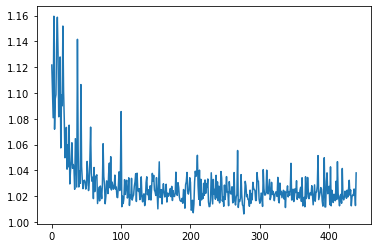

In [0]:
if 'train' in option:
  train()

import matplotlib.pyplot as plt
plt.plot(training_perp_tab)

#Validation of the Model <a name="valid"></a>

## Execution Validation

In [0]:
if 'valid' in option:
  #initialize the validation data in DataClass
  valid_set = DeepNovoTrainDataset(input_feature_file_valid,
                                          input_spectrum_file_valid)
  valid_data_loader = torch.utils.data.DataLoader(dataset=valid_set,
                                                          batch_size=batch_size,
                                                          shuffle=False,
                                                          num_workers=num_workers,
                                                          collate_fn=collate_func)
  #Feed validation data to the Model
  forward_deepnovo, backward_deepnovo, init_net = build_model(training=False)
  forward_deepnovo.eval()
  backward_deepnovo.eval()
  #compute validation loss with the validation function
  validation_loss = validation(forward_deepnovo, backward_deepnovo, init_net, valid_data_loader)
  print(f"validation perplexity: {perplexity(validation_loss)}")

input spectrum file: Test_files/spectrum_smbp.mgf
input feature file: Test_files/features_smbp.csv.valid
read cached spectrum locations
load pretrained model
validation perplexity: 1.3300293110139931


# Denovo Prediction <a name="denovo"></a>

##Denovo Path <a name="denovo_path"></a>

In [0]:
# denovo path files
denovo_input_spectrum_file = "Test_files/spectrum_smbp.mgf"
denovo_input_feature_file = "Test_files/features_smbp.csv.test"

#Path of the denovo output predictions
denovo_output_file = denovo_input_feature_file + ".deepnovo_denovo"

predicted_format = "deepnovo"
target_file = denovo_input_feature_file
predicted_file = denovo_output_file

#Name of the files produced after denovo prediction
accuracy_file = predicted_file + ".accuracy"
denovo_only_file = predicted_file + ".denovo_only"
scan2fea_file = predicted_file + ".scan2fea"
multifea_file = predicted_file + ".multifea"

## Denovo Dataset Data reader <a name="denovo_datareader"></a>

In [0]:
class DeepNovoDenovoDataset(DeepNovoTrainDataset):
    # override _get_feature method in the dataclass DeepNovoTrainDataset
    def _get_feature(self, feature: DDAFeature) -> DenovoData:
        spectrum_location = self.spectrum_location_dict[feature.scan]
        self.input_spectrum_handle.seek(spectrum_location)
        # parse header lines
        line = self.input_spectrum_handle.readline()
        assert "BEGIN IONS" in line, "Error: wrong input BEGIN IONS"
        line = self.input_spectrum_handle.readline()
        assert "TITLE=" in line, "Error: wrong input TITLE="
        line = self.input_spectrum_handle.readline()
        assert "PEPMASS=" in line, "Error: wrong input PEPMASS="
        line = self.input_spectrum_handle.readline()
        assert "CHARGE=" in line, "Error: wrong input CHARGE="
        line = self.input_spectrum_handle.readline()
        assert "SCANS=" in line, "Error: wrong input SCANS="
        line = self.input_spectrum_handle.readline()
        assert "RTINSECONDS=" in line, "Error: wrong input RTINSECONDS="
        mz_list, intensity_list = self._parse_spectrum_ion()
        peak_location, peak_intensity, spectrum_representation = process_peaks(mz_list, intensity_list, feature.mass)

        return DenovoData(peak_location=peak_location,
                          peak_intensity=peak_intensity,
                          spectrum_representation=spectrum_representation,
                          original_dda_feature=feature)

## Writer Functions <a name="denovo_writer"></a>

In [0]:
@dataclass
class BeamSearchedSequence:
    sequence: list  # list of aa id
    position_score: list
    score: float  # average by length score


class DenovoWriter(object):
    def __init__(self, denovo_output_file):
        self.output_handle = open(denovo_output_file, 'w')
        header_list = ["feature_id",
                       "feature_area",
                       "predicted_sequence",
                       "predicted_score",
                       "predicted_position_score",
                       "precursor_mz",
                       "precursor_charge",
                       "protein_access_id",
                       "scan_list_middle",
                       "scan_list_original",
                       "predicted_score_max"]
        header_row = "\t".join(header_list)
        print(header_row, file=self.output_handle, end='\n')

    def close(self):
        self.output_handle.close()

    def write(self, dda_original_feature: DDAFeature, searched_sequence: BeamSearchedSequence):
        """
        Write the rows of prediction, outputed from the BeamSearch
        :param dda_original_feature:
        :param searched_sequence:
        :return: -> Print predicted row
        """
        feature_id = dda_original_feature.feature_id
        feature_area = dda_original_feature.feature_area
        precursor_mz = str(dda_original_feature.mz)
        precursor_charge = str(dda_original_feature.z)
        scan_list_middle = dda_original_feature.scan
        scan_list_original = dda_original_feature.scan
        if searched_sequence.sequence:
            predicted_sequence = ','.join([vocab_reverse[aa_id] for
                                           aa_id in searched_sequence.sequence])
            predicted_score = "{:.2f}".format(searched_sequence.score)
            predicted_score_max = predicted_score
            predicted_position_score = ','.join(['{0:.2f}'.format(x) for x in searched_sequence.position_score])
            protein_access_id = 'DENOVO'
        else:
            predicted_sequence = ""
            predicted_score = ""
            predicted_score_max = ""
            predicted_position_score = ""
            protein_access_id = ""
        predicted_row = "\t".join([feature_id,
                                   feature_area,
                                   predicted_sequence,
                                   predicted_score,
                                   predicted_position_score,
                                   precursor_mz,
                                   precursor_charge,
                                   protein_access_id,
                                   scan_list_middle,
                                   scan_list_original,
                                   predicted_score_max])
        print(predicted_row, file=self.output_handle, end="\n")

    def __del__(self):
        self.close()

## KnapSack Implementation <a name="knapsack"></a>
If the file knapsack.py is not present in the root path of the program, it will build a new one. (it takes time to build, ~40min with Colab).
But you can upload it from the data included as it is a constant. 

In [0]:
class Direction(Enum):
    forward = 1
    backward = 2

@dataclass
class BeamSearchStartPoint:
    prefix_mass: float
    suffix_mass: float
    mass_tolerance: float
    direction: Direction


@dataclass
class DenovoResult:
    dda_feature: DDAFeature
    best_beam_search_sequence: BeamSearchedSequence


class KnapsackSearcher(object):
    """
    Implementation of the Knapsack Algorithm.
    If Knapsack not present in the source file, build a new one based on the parameters set
    in global variables (vocabulary and masses)
    """
    def __init__(self, MZ_MAX, knapsack_file):
        self.knapsack_file = knapsack_file
        self.MZ_MAX = MZ_MAX
        self.knapsack_aa_resolution = KNAPSACK_AA_RESOLUTION
        if os.path.isfile(knapsack_file):
            print("KnapsackSearcher.__init__(): load knapsack matrix")
            self.knapsack_matrix = np.load(knapsack_file)
        else:
            print("KnapsackSearcher.__init__(): build knapsack matrix from scratch")
            self.knapsack_matrix = self._build_knapsack()

    def _build_knapsack(self):
        max_mass = self.MZ_MAX - mass_N_terminus - mass_C_terminus
        max_mass_round = int(round(max_mass * self.knapsack_aa_resolution))
        max_mass_upperbound = max_mass_round + self.knapsack_aa_resolution
        knapsack_matrix = np.zeros(shape=(vocab_size, max_mass_upperbound), dtype=bool)
        for aa_id in tqdm(range(3, vocab_size)):
            mass_aa = int(round(mass_ID[aa_id] * self.knapsack_aa_resolution))

            for col in range(max_mass_upperbound):
                current_mass = col + 1
                if current_mass < mass_aa:
                    knapsack_matrix[aa_id, col] = False
                elif current_mass == mass_aa:
                    knapsack_matrix[aa_id, col] = True
                elif current_mass > mass_aa:
                    sub_mass = current_mass - mass_aa
                    sub_col = sub_mass - 1
                    if np.sum(knapsack_matrix[:, sub_col]) > 0:
                        knapsack_matrix[aa_id, col] = True
                        knapsack_matrix[:, col] = np.logical_or(knapsack_matrix[:, col], knapsack_matrix[:, sub_col])
                    else:
                        knapsack_matrix[aa_id, col] = False
        np.save(self.knapsack_file, knapsack_matrix)
        return knapsack_matrix

    def search_knapsack(self, mass, knapsack_tolerance):
        mass_round = int(round(mass * self.knapsack_aa_resolution))
        mass_upperbound = mass_round + knapsack_tolerance
        mass_lowerbound = mass_round - knapsack_tolerance
        if mass_upperbound < mass_AA_min_round:
            return []
        mass_lowerbound_col = mass_lowerbound - 1
        mass_upperbound_col = mass_upperbound - 1
        candidate_aa_id = np.flatnonzero(np.any(self.knapsack_matrix[:, mass_lowerbound_col:(mass_upperbound_col + 1)],
                                                axis=1))
        return candidate_aa_id.tolist()



## ION CNN Denovo <a name="ioncnn"></a>

In [0]:
@dataclass
class SearchPath:
    aa_id_list: list
    aa_seq_mass: float
    score_list: list
    score_sum: float
    lstm_state: tuple  # state tuple store in search path is of shape [num_lstm_layers, num_units]
    direction: Direction

@dataclass
class SearchEntry:
    feature_index: int
    current_path_list: list  # list of search paths
    spectrum_state: tuple  # tuple of (peak_location, peak_intensity)


class IonCNNDenovo(object):
    def __init__(self, MZ_MAX, knapsack_file, beam_size):
        self.MZ_MAX = MZ_MAX
        self.beam_size = beam_size
        self.knapsack_searcher = KnapsackSearcher(MZ_MAX, knapsack_file)

    def _beam_search(self, model_wrapper: InferenceModelWrapper,
                     feature_dp_batch: list, start_point_batch: list) -> list:
        """

        :param model_wrapper:
        :param feature_dp_batch: list of DenovoData
        :param start_point_batch:
        :return:
        """
        num_features = len(feature_dp_batch)
        top_path_batch = [[] for _ in range(num_features)]

        direction_cint_map = {Direction.forward: 0, Direction.backward: 1}

        direction = start_point_batch[0].direction
        if direction == Direction.forward:
            get_start_mass = lambda x: x.prefix_mass
            first_label = GO_ID
            last_label = EOS_ID
        elif direction == Direction.backward:
            get_start_mass = lambda x: x.suffix_mass
            first_label = EOS_ID
            last_label = GO_ID
        else:
            raise ValueError('direction neither forward nor backward')

        # step 1: extract original spectrum
        batch_peak_location = np.array([x.peak_location for x in feature_dp_batch])
        batch_peak_intensity = np.array([x.peak_intensity for x in feature_dp_batch])
        batch_spectrum_representation = np.array([x.spectrum_representation for x in feature_dp_batch])

        batch_peak_location = torch.from_numpy(batch_peak_location).to(device)
        batch_peak_intensity = torch.from_numpy(batch_peak_intensity).to(device)
        batch_spectrum_representation = torch.from_numpy(batch_spectrum_representation).to(device)

        initial_hidden_state_tuple = model_wrapper.initial_hidden_state(batch_spectrum_representation) if \
            use_lstm else None

        # initialize activate search list
        active_search_list = []
        for feature_index in range(num_features):
            # all feature in the same batch should be from same direction
            assert direction == start_point_batch[feature_index].direction

            spectrum_state = (batch_peak_location[feature_index], batch_peak_intensity[feature_index])

            if use_lstm:
                lstm_state_temp = (initial_hidden_state_tuple[0][:, feature_index, :],
                                   initial_hidden_state_tuple[1][:, feature_index, :]
                                   )
            else:
                lstm_state_temp = None

            path = SearchPath(
                aa_id_list=[first_label],
                aa_seq_mass=get_start_mass(start_point_batch[feature_index]),
                score_list=[0.0],
                score_sum=0.0,
                lstm_state=lstm_state_temp,
                direction=direction,
            )
            search_entry = SearchEntry(
                feature_index=feature_index,
                current_path_list=[path],
                spectrum_state=spectrum_state,
            )
            active_search_list.append(search_entry)

        # repeat STEP 2, 3, 4 until the active_search_list is empty.
        while True:
            # STEP 2: gather data from active search entries and group into blocks.

            # model input
            block_aa_id_input = []
            block_ion_location = []
            block_peak_location = []
            block_peak_intensity = []
            block_lstm_h = []
            block_lstm_c = []
            # data stored in path
            block_aa_id_list = []
            block_aa_seq_mass = []
            block_score_list = []
            block_score_sum = []
            block_knapsack_candidates = []

            # store the number of paths of each search entry in the big blocks
            #     to retrieve the info of each search entry later in STEP 4.
            search_entry_size = [0] * len(active_search_list)

            for entry_index, search_entry in enumerate(active_search_list):
                feature_index = search_entry.feature_index
                current_path_list = search_entry.current_path_list
                precursor_mass = feature_dp_batch[feature_index].original_dda_feature.mass
                peak_mass_tolerance = start_point_batch[feature_index].mass_tolerance

                for path in current_path_list:
                    aa_id_list = path.aa_id_list
                    aa_id = aa_id_list[-1]
                    score_sum = path.score_sum
                    aa_seq_mass = path.aa_seq_mass
                    score_list = path.score_list
                    original_spectrum_tuple = search_entry.spectrum_state
                    lstm_state_tuple = path.lstm_state

                    if aa_id == last_label:
                        if abs(aa_seq_mass - precursor_mass) <= peak_mass_tolerance:
                            seq = aa_id_list[1:-1]
                            trunc_score_list = score_list[1:-1]
                            if direction == Direction.backward:
                                seq = seq[::-1]
                                trunc_score_list = trunc_score_list[::-1]

                            top_path_batch[feature_index].append(
                                BeamSearchedSequence(sequence=seq,
                                                     position_score=trunc_score_list,
                                                     score=path.score_sum / len(seq))
                            )
                        continue

                    ion_location = get_ion_index(precursor_mass, aa_seq_mass, direction_cint_map[direction])  # [26,8]

                    residual_mass = precursor_mass - aa_seq_mass - mass_ID[last_label]
                    knapsack_tolerance = int(round(peak_mass_tolerance * KNAPSACK_AA_RESOLUTION))
                    knapsack_candidates = self.knapsack_searcher.search_knapsack(residual_mass, knapsack_tolerance)

                    if not knapsack_candidates:
                        # if not possible aa, force it to stop.
                        knapsack_candidates.append(last_label)

                    block_ion_location.append(ion_location)
                    block_aa_id_input.append(aa_id)
                    # get hidden state block
                    block_peak_location.append(original_spectrum_tuple[0])
                    block_peak_intensity.append(original_spectrum_tuple[1])
                    if use_lstm:
                        block_lstm_h.append(lstm_state_tuple[0])
                        block_lstm_c.append(lstm_state_tuple[1])

                    block_aa_id_list.append(aa_id_list)
                    block_aa_seq_mass.append(aa_seq_mass)
                    block_score_list.append(score_list)
                    block_score_sum.append(score_sum)
                    block_knapsack_candidates.append(knapsack_candidates)
                    # record the size of each search entry in the blocks
                    search_entry_size[entry_index] += 1

            # step 3 run model on data blocks to predict next AA.
            #     output is stored in current_log_prob
            # assert block_aa_id_list, 'IonCNNDenovo._beam_search(): aa_id_list is empty.'
            if not block_ion_location:
                # all search entry finished in the previous step
                break

            block_ion_location = torch.from_numpy(np.array(block_ion_location)).to(device)  # [batch, 26, 8, 10]
            block_ion_location = torch.unsqueeze(block_ion_location, dim=1)  # [batch, 1, 26, 8]
            block_peak_location = torch.stack(block_peak_location, dim=0).contiguous()
            block_peak_intensity = torch.stack(block_peak_intensity, dim=0).contiguous()
            if use_lstm:
                block_lstm_h = torch.stack(block_lstm_h, dim=1).contiguous()
                block_lstm_c = torch.stack(block_lstm_c, dim=1).contiguous()
                block_state_tuple = (block_lstm_h, block_lstm_c)
                block_aa_id_input = torch.from_numpy(np.array(block_aa_id_input, dtype=np.int64)).unsqueeze(1).to(
                    device)
            else:
                block_state_tuple = None
                block_aa_id_input = None

            current_log_prob, new_state_tuple = model_wrapper.step(block_ion_location,
                                                                   block_peak_location,
                                                                   block_peak_intensity,
                                                                   block_aa_id_input,
                                                                   block_state_tuple,
                                                                   direction)
            # transfer log_prob back to cpu
            current_log_prob = current_log_prob.cpu().numpy()

            # STEP 4: retrieve data from blocks to update the active_search_list
            #     with knapsack dynamic programming and beam search.
            block_index = 0
            for entry_index, search_entry in enumerate(active_search_list):
                new_path_list = []
                direction = search_entry.current_path_list[0].direction
                for index in range(block_index, block_index + search_entry_size[entry_index]):
                    for aa_id in block_knapsack_candidates[index]:
                        if aa_id > 2:
                            # do not add score of GO, EOS, PAD
                            new_score_list = block_score_list[index] + [current_log_prob[index][aa_id]]
                            new_score_sum = block_score_sum[index] + current_log_prob[index][aa_id]
                        else:
                            new_score_list = block_score_list[index] + [0.0]
                            new_score_sum = block_score_sum[index] + 0.0

                        if use_lstm:
                            new_path_state_tuple = (new_state_tuple[0][:, index, :], new_state_tuple[1][:, index, :])
                        else:
                            new_path_state_tuple = None

                        new_path = SearchPath(
                            aa_id_list=block_aa_id_list[index] + [aa_id],
                            aa_seq_mass=block_aa_seq_mass[index] + mass_ID[aa_id],
                            score_list=new_score_list,
                            score_sum=new_score_sum,
                            lstm_state=new_path_state_tuple,
                            direction=direction
                        )
                        new_path_list.append(new_path)
                if len(new_path_list) > self.beam_size:
                    new_path_score = np.array([x.score_sum for x in new_path_list])
                    top_k_index = np.argpartition(-new_path_score, self.beam_size)[:self.beam_size]
                    search_entry.current_path_list = [new_path_list[ii] for ii in top_k_index]
                else:
                    search_entry.current_path_list = new_path_list

                block_index += search_entry_size[entry_index]

            active_search_list = [x for x in active_search_list if x.current_path_list]

            if not active_search_list:
                break
        return top_path_batch

    @staticmethod
    def _get_start_point(feature_dp_batch: list) -> tuple:
        mass_GO = mass_ID[GO_ID]
        forward_start_point_lists = [BeamSearchStartPoint(prefix_mass=mass_GO,
                                                          suffix_mass=feature_dp.original_dda_feature.mass - mass_GO,
                                                          mass_tolerance=PRECURSOR_MASS_PRECISION_TOLERANCE,
                                                          direction=Direction.forward)
                                     for feature_dp in feature_dp_batch]

        mass_EOS = mass_ID[EOS_ID]
        backward_start_point_lists = [BeamSearchStartPoint(prefix_mass=feature_dp.original_dda_feature.mass - mass_EOS,
                                                           suffix_mass=mass_EOS,
                                                           mass_tolerance=PRECURSOR_MASS_PRECISION_TOLERANCE,
                                                           direction=Direction.backward)
                                      for feature_dp in feature_dp_batch]
        return forward_start_point_lists, backward_start_point_lists

    @staticmethod
    def _select_path(feature_dp_batch: list, top_candidate_batch: list) -> list:
        """
        for each feature, select the best denovo sequence given by DeepNovo model
        :param feature_dp_batch: list of DenovoData
        :param top_candidate_batch: defined in _search_denovo_batch
        :return:
        list of DenovoResult
        """
        feature_batch_size = len(feature_dp_batch)

        refine_batch = [[] for x in range(feature_batch_size)]
        for feature_index in range(feature_batch_size):
            precursor_mass = feature_dp_batch[feature_index].original_dda_feature.mass
            candidate_list = top_candidate_batch[feature_index]
            for beam_search_sequence in candidate_list:
                sequence = beam_search_sequence.sequence
                sequence_mass = sum(mass_ID[x] for x in sequence)
                sequence_mass += mass_ID[GO_ID] + mass_ID[EOS_ID]
                if abs(sequence_mass - precursor_mass) <= PRECURSOR_MASS_PRECISION_TOLERANCE:
                    refine_batch[feature_index].append(beam_search_sequence)
        predicted_batch = []
        for feature_index in range(feature_batch_size):
            candidate_list = refine_batch[feature_index]
            if not candidate_list:
                best_beam_search_sequence = BeamSearchedSequence(
                    sequence=[],
                    position_score=[],
                    score=-float('inf')
                )
            else:
                # sort candidate sequence by average position score
                best_beam_search_sequence = max(candidate_list, key=lambda x: x.score)

            denovo_result = DenovoResult(
                dda_feature=feature_dp_batch[feature_index].original_dda_feature,
                best_beam_search_sequence=best_beam_search_sequence
            )
            predicted_batch.append(denovo_result)
        return predicted_batch

    def _search_denovo_batch(self, feature_dp_batch: list, model_wrapper: InferenceModelWrapper) -> list:
        start_time = time.time()
        feature_batch_size = len(feature_dp_batch)
        start_points_tuple = self._get_start_point(feature_dp_batch)
        top_candidate_batch = [[] for x in range(feature_batch_size)]

        for start_points in start_points_tuple:
            beam_search_result_batch = self._beam_search(model_wrapper, feature_dp_batch, start_points)
            for feature_index in range(feature_batch_size):
                top_candidate_batch[feature_index].extend(beam_search_result_batch[feature_index])
        predicted_batch = self._select_path(feature_dp_batch, top_candidate_batch)
        test_time = time.time() - start_time
        print("beam_search(): batch time {}s".format(test_time))
        return predicted_batch

    def search_denovo(self, model_wrapper: InferenceModelWrapper,
                      beam_search_reader: DeepNovoDenovoDataset, denovo_writer: DenovoWriter):
        print("start beam search denovo")
        predicted_denovo_list = []

        test_set_iter = chunks(list(range(len(beam_search_reader))), n=batch_size)
        total_batch_num = int(len(beam_search_reader) / batch_size)
        for index, feature_batch_index in enumerate(test_set_iter):
            feature_dp_batch = [beam_search_reader[i] for i in feature_batch_index]
            print("Read {}th/{} batches".format(index, total_batch_num))
            predicted_batch = self._search_denovo_batch(feature_dp_batch, model_wrapper)
            predicted_denovo_list += predicted_batch
            for denovo_result in predicted_batch:
                denovo_writer.write(denovo_result.dda_feature, denovo_result.best_beam_search_sequence)

        return predicted_denovo_list


##Chunk function

In [0]:
def chunks(l, n: int):
    for i in range(0, len(l), n):
        yield l[i:i + n]

##Launch DeepNovo denovo prediction <a name="denovo_launch"></a>

In [0]:
beam_size = beam_size_param #by default 5
if 'denovo' in option:
  data_reader = DeepNovoDenovoDataset(feature_filename=denovo_input_feature_file,
                                              spectrum_filename=denovo_input_spectrum_file)
  print('data_reader done \n')
  print('IonCNNDenovo starting \n')
  denovo_worker = IonCNNDenovo(MZ_MAX,
                                      knapsack_file,
                                      beam_size=beam_size)
  print('Building Model ... \n')
  forward_deepnovo, backward_deepnovo, init_net = build_model(training=False)
  print('Wrapper \n')
  model_wrapper = InferenceModelWrapper(forward_deepnovo, backward_deepnovo, init_net)
  print('Writing ... \n')
  writer = DenovoWriter(denovo_output_file)

  denovo_worker.search_denovo(model_wrapper, data_reader, writer)

input spectrum file: Test_files/spectrum_smbp.mgf
input feature file: Test_files/features_smbp.csv.test
read cached spectrum locations
data_reader done 

IonCNNDenovo starting 

KnapsackSearcher.__init__(): load knapsack matrix
Building Model ... 

load pretrained model
Wrapper 

Writing ... 

start beam search denovo
Read 0th/46 batches


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


beam_search(): batch time 0.43567872047424316s
Read 1th/46 batches
beam_search(): batch time 0.41751766204833984s
Read 2th/46 batches
beam_search(): batch time 0.4966866970062256s
Read 3th/46 batches
beam_search(): batch time 0.4173126220703125s
Read 4th/46 batches
beam_search(): batch time 0.42495107650756836s
Read 5th/46 batches
beam_search(): batch time 0.47627758979797363s
Read 6th/46 batches
beam_search(): batch time 0.57391357421875s
Read 7th/46 batches
beam_search(): batch time 0.44745898246765137s
Read 8th/46 batches
beam_search(): batch time 0.49332141876220703s
Read 9th/46 batches
beam_search(): batch time 0.36672544479370117s
Read 10th/46 batches
beam_search(): batch time 0.5602383613586426s
Read 11th/46 batches
beam_search(): batch time 0.735649824142456s
Read 12th/46 batches
beam_search(): batch time 0.5985617637634277s
Read 13th/46 batches
beam_search(): batch time 0.4346141815185547s
Read 14th/46 batches
beam_search(): batch time 0.36309289932250977s
Read 15th/46 batches

# Testing Model <a name="test"></a>

## Testing File Path <a name="test_path"></a>

Select the path of the testing dataset (usualy part of the initial dataset randomely split in training, valid and testing parts)

In [0]:
input_spectrum_file_test = "Test_files/spectrum_smbp.mgf"
input_feature_file_test = "Test_files/feature_smbp.csv.test"

## Worker Test function <a name="test_worker"></a>

In [0]:
class WorkerTest(object):
  """
     The WorkerTest is a function that will compare the sequence predicted by the
     denovo function with the original sequence (if available) and display the accuracy
     of the model trained, on these 'denovo' testing sequences
  """


  def __init__(self):
    print("".join(["="] * 80)) # section-separating line
    print("WorkerTest.__init__()")

    #get all the variables needed
    self.MZ_MAX = MZ_MAX

    self.target_file = target_file #denovo input
    self.predicted_file = predicted_file #denovo output
    self.predicted_format = predicted_format # tag "deepnovo"
    
    #get the path for the output of the function
    self.accuracy_file = accuracy_file 
    self.denovo_only_file = denovo_only_file
    self.scan2fea_file = scan2fea_file
    self.multifea_file = multifea_file

    print("target_file = {0:s}".format(self.target_file))
    print("predicted_file = {0:s}".format(self.predicted_file))
    print("predicted_format = {0:s}".format(self.predicted_format))
    print("accuracy_file = {0:s}".format(self.accuracy_file))
    print("denovo_only_file = {0:s}".format(self.denovo_only_file))
    print("scan2fea_file = {0:s}".format(self.scan2fea_file))
    print("multifea_file = {0:s}".format(self.multifea_file))

    self.target_dict = {}
    self.predicted_list = []


  def test_accuracy(self, db_peptide_list=None):
    """"""

    print("".join(["="] * 80)) # section-separating line
    print("WorkerTest.test_accuracy()")

    # write the accuracy of predicted peptides
    accuracy_handle = open(self.accuracy_file, 'w')
    header_list = ["feature_id",
                   "feature_area",
                   "target_sequence",
                   "predicted_sequence",
                   "predicted_score",
                   "recall_AA",
                   "predicted_len",
                   "target_len",
                   "scan_list_middle",
                   "scan_list_original"]
    header_row = "\t".join(header_list)
    print(header_row, file=accuracy_handle, end="\n")

    # write denovo_only peptides (sequence with a reference to coompare)
    denovo_only_handle = open(self.denovo_only_file, 'w')
    header_list = ["feature_id",
                   "feature_area",
                   "predicted_sequence",
                   "predicted_score",
                   "predicted_score_max",
                   "scan_list_middle",
                   "scan_list_original"]
    header_row = "\t".join(header_list)
    print(header_row, file=denovo_only_handle, end="\n")

    self._get_target()
    target_count_total = len(self.target_dict)
    target_len_total = sum([len(x) for x in self.target_dict.values()])
    target_dict_db = {}

    #Depricated if no use of PEAKS DB to compare the sequence predicted (in SMBP case, use of MASCOT)

    # this part is tricky!
    # some target peptides are reported by PEAKS DB but not found in
    #   db_peptide_list due to mistakes in cleavage rules.
    # if db_peptide_list is given, we only consider those target peptides,
    #   otherwise, use all target peptides
    if db_peptide_list is not None:
      for feature_id, target in self.target_dict.items():
        target_simplied = target
        # remove the extension 'mod' from variable modifications
        target_simplied = ['M' if x=='M(Oxidation)' else x for x in target_simplied]
        target_simplied = ['N' if x=='N(Deamidation)' else x for x in target_simplied]
        target_simplied = ['Q' if x=='Q(Deamidation)' else x for x in target_simplied]

        #target_simplied = ['M' if x=='M(Oxidated)' else x for x in target_simplied]
        #target_simplied = ['Q' if x=='Q(Deamidated)' else x for x in target_simplied]
        #target_simplied = ['C' if x=='C(Carboxymethyl)' else x for x in target_simplied]

        if target_simplied in db_peptide_list:
          target_dict_db[feature_id] = target
        else:
          print("target not found: ", target_simplied)
    #==========================================================================
    else:
      target_dict_db = self.target_dict
    target_count_db = len(target_dict_db)
    target_len_db = sum([len(x) for x in target_dict_db.values()])

    # we also skip target peptides with precursor_mass > MZ_MAX
    target_dict_db_mass = {}
    for feature_id, peptide in target_dict_db.items():
      if self._compute_peptide_mass(peptide) <= self.MZ_MAX:
        target_dict_db_mass[feature_id] = peptide
    target_count_db_mass = len(target_dict_db_mass)
    target_len_db_mass = sum([len(x) for x in target_dict_db_mass.values()])

    # read predicted peptides from deepnovo or peaks
    if predicted_format == "deepnovo":
      self._get_predicted()
    else:
      self._get_predicted_peaks()

    # note that the prediction has already skipped precursor_mass > MZ_MAX
    # we also skip predicted peptides whose feature_id's are not in target_dict_db_mass
    predicted_count_mass = len(self.predicted_list)
    predicted_count_mass_db = 0
    predicted_len_mass_db = 0
    predicted_only = 0
    # the recall is calculated on remaining peptides
    recall_AA_total = 0.0
    recall_peptide_total = 0.0

    # record scan with multiple features
    scan_dict = {}

    for index, predicted in enumerate(self.predicted_list):

      feature_id = predicted["feature_id"]
      feature_area = str(predicted["feature_area"])
      feature_scan_list_middle = predicted["scan_list_middle"]
      feature_scan_list_original = predicted["scan_list_original"]
      if feature_scan_list_original:
        for scan in re.split(';|\r|\n', feature_scan_list_original):
          if scan in scan_dict:
            scan_dict[scan]["feature_count"] += 1
            scan_dict[scan]["feature_list"].append(feature_id)
          else:
            scan_dict[scan] = {}
            scan_dict[scan]["feature_count"] = 1
            scan_dict[scan]["feature_list"] = [feature_id]

      if feature_id in target_dict_db_mass:

        predicted_count_mass_db += 1

        target = target_dict_db_mass[feature_id]
        target_len= len(target)

        # if >= 1 denovo peptides reported, calculate the best accuracy
        best_recall_AA = 0
        best_predicted_sequence = predicted["sequence"][0]
        best_predicted_score = predicted["score"][0]
        for predicted_sequence, predicted_score in zip(predicted["sequence"], predicted["score"]):
          predicted_AA_id = [vocab[x] for x in predicted_sequence]
          target_AA_id = [vocab[x] for x in target]
          recall_AA = self._match_AA_novor(target_AA_id, predicted_AA_id)
          if (recall_AA > best_recall_AA
              or (recall_AA == best_recall_AA and predicted_score > best_predicted_score)):
            best_recall_AA = recall_AA
            best_predicted_sequence = predicted_sequence[:]
            best_predicted_score = predicted_score
        recall_AA = best_recall_AA
        predicted_sequence = best_predicted_sequence[:]
        predicted_score = best_predicted_score

        recall_AA_total += recall_AA
        if recall_AA == target_len:
          recall_peptide_total += 1
        predicted_len= len(predicted_sequence)
        predicted_len_mass_db += predicted_len

        # convert to string format to print out
        target_sequence = ",".join(target)
        predicted_sequence = ",".join(predicted_sequence)
        predicted_score = "{0:.2f}".format(predicted_score)
        recall_AA = "{0:d}".format(recall_AA)
        predicted_len = "{0:d}".format(predicted_len)
        target_len = "{0:d}".format(target_len)
        print_list = [feature_id,
                      feature_area,
                      target_sequence,
                      predicted_sequence,
                      predicted_score,
                      recall_AA,
                      predicted_len,
                      target_len,
                      feature_scan_list_middle,
                      feature_scan_list_original]
        print_row = "\t".join(print_list)
        print(print_row, file=accuracy_handle, end="\n")
      else:
        predicted_only += 1
        predicted_sequence = ';'.join([','.join(x) for x in predicted["sequence"]])
        predicted_score = ';'.join(['{0:.2f}'.format(x) for x in predicted["score"]])
        if predicted["score"]:
          predicted_score_max = '{0:.2f}'.format(np.max(predicted["score"]))
        else:
          predicted_score_max = ''
        print_list = [feature_id,
                      feature_area,
                      predicted_sequence,
                      predicted_score,
                      predicted_score_max,
                      feature_scan_list_middle,
                      feature_scan_list_original]
        print_row = "\t".join(print_list)
        print(print_row, file=denovo_only_handle, end="\n")

    accuracy_handle.close()
    denovo_only_handle.close()

    multifea_dict = {}
    for scan_id, value in scan_dict.items():
      feature_count = value["feature_count"]
      feature_list = value["feature_list"]
      if feature_count > 1:
        for feature_id in feature_list:
          if feature_id in multifea_dict:
            multifea_dict[feature_id].append(scan_id + ':' + str(feature_count))
          else:
            multifea_dict[feature_id] = [scan_id + ':' + str(feature_count)]

    #scan2fea_file. Display the nomber of identic scan in a the spectrum
    with open(self.scan2fea_file, 'w') as handle:
      header_list = ["scan_id",
                     "feature_count",
                     "feature_list"]
      header_row = "\t".join(header_list)
      print(header_row, file=handle, end="\n")
      for scan_id, value in scan_dict.items():
        print_list = [scan_id,
                      str(value["feature_count"]),
                      ";".join(value["feature_list"])]
        print_row = "\t".join(print_list)
        print(print_row, file=handle, end="\n")
    #multifea_file. Display wich scans are doubles in spectrum
    with open(self.multifea_file, 'w') as handle:
      header_list = ["feature_id",
                     "scan_list"]
      header_row = "\t".join(header_list)
      print(header_row, file=handle, end="\n")
      for feature_id, scan_list in multifea_dict.items():
        print_list = [feature_id,
                      ";".join(scan_list)]
        print_row = "\t".join(print_list)
        print(print_row, file=handle, end="\n")

    print("target_count_total = {0:d}".format(target_count_total))
    print("target_len_total = {0:d}".format(target_len_total))
    print("target_count_db = {0:d}".format(target_count_db))
    print("target_len_db = {0:d}".format(target_len_db))
    print("target_count_db_mass: {0:d}".format(target_count_db_mass))
    print("target_len_db_mass: {0:d}".format(target_len_db_mass))

    print("predicted_count_mass: {0:d}".format(predicted_count_mass))
    print("predicted_count_mass_db: {0:d}".format(predicted_count_mass_db))
    print("predicted_len_mass_db: {0:d}".format(predicted_len_mass_db))
    print("predicted_only: {0:d}".format(predicted_only))

    #if added in case of failed training to avoid an error.
    if target_len_total != 0:
      print("recall_AA_total = {0:.4f}".format(recall_AA_total / target_len_total))
    if target_len_db != 0:
      print("recall_AA_db = {0:.4f}".format(recall_AA_total / target_len_db))
    if target_len_db_mass != 0:
      print("recall_AA_db_mass = {0:.4f}".format(recall_AA_total / target_len_db_mass))
    if target_count_total != 0:
      print("recall_peptide_total = {0:.4f}".format(recall_peptide_total / target_count_total))
    if target_count_db != 0:
      print("recall_peptide_db = {0:.4f}".format(recall_peptide_total / target_count_db))
    if target_count_db_mass != 0:
      print("recall_peptide_db_mass = {0:.4f}".format(recall_peptide_total / target_count_db_mass))
    if predicted_len_mass_db != 0:
      print("precision_AA_mass_db  = {0:.4f}".format(recall_AA_total / predicted_len_mass_db))
    if predicted_count_mass_db != 0:
      print("precision_peptide_mass_db  = {0:.4f}".format(recall_peptide_total / predicted_count_mass_db))
  
  
  def _compute_peptide_mass(self, peptide):
    """
    Add start and en mass to the aa chains
    """
    #print("".join(["="] * 80)) # section-separating line
    #print("WorkerTest._compute_peptide_mass()")
    peptide_mass = (mass_N_terminus
                    + sum(mass_AA[aa] for aa in peptide)
                    + mass_C_terminus)

    return peptide_mass


  def _get_predicted(self):
    print("".join(["="] * 80)) # section-separating line
    print("WorkerTest._get_predicted()")

    predicted_list = []
    col_feature_id = pcol_feature_id
    col_feature_area = pcol_feature_area
    col_sequence = pcol_sequence
    col_score = pcol_score
    col_scan_list_middle = pcol_scan_list_middle
    col_scan_list_original = pcol_scan_list_original
    with open(self.predicted_file, 'r') as handle:
      # header
      handle.readline()
      for line in handle:
        line_split = re.split('\t|\n', line)
        predicted = {}
        predicted["feature_id"] = line_split[col_feature_id]
        predicted["feature_area"] = float(line_split[col_feature_area])
        predicted["scan_list_middle"] = line_split[col_scan_list_middle]
        predicted["scan_list_original"] = line_split[col_scan_list_original]
        if line_split[col_sequence]: # not empty sequence
          predicted["sequence"] = [re.split(',', x)
                                   for x in re.split(';', line_split[col_sequence])]
          predicted["score"] = [float(x)
                                for x in re.split(';', line_split[col_score])]
        else: 
          predicted["sequence"] = [[]]
          predicted["score"] = [-999]
        predicted_list.append(predicted)

    self.predicted_list = predicted_list


  def _get_predicted_peaks(self):
    print("".join(["="] * 80)) # section-separating line
    print("WorkerTest._get_predicted_peaks()")

    predicted_list = []
    col_fraction_id = 0
    fraction_id_map = {'1':'1',
                       '2':'10',
                       '3':'11',
                       '4':'12',
                       '5':'2',
                       '6':'3',
                       '7':'4',
                       '8':'5',
                       '9':'6',
                       '10':'7',
                       '11':'8',
                       '12':'9',
                      }
    col_scan_id = 1
    col_sequence = 3
    with open(self.predicted_file, 'r') as handle:
      # header
      handle.readline()
      for line in handle:
        line_split = re.split(',|\n', line)
        predicted = {}
        predicted["feature_id"] = "F" + line_split[col_fraction_id] + ":" + line_split[col_scan_id]
        raw_sequence = line_split[col_sequence]
        assert raw_sequence, "Error: wrong format."
        predicted["sequence"] = self._parse_sequence(raw_sequence)
        
        # skip peptides with precursor_mass > MZ_MAX
        if self._compute_peptide_mass(predicted["sequence"]) > self.MZ_MAX:
          continue
        predicted["feature_area"] = 0
        predicted["scan_list_middle"] = ""
        predicted["scan_list_original"] = ""
        predicted["sequence"] = [predicted["sequence"]]
        predicted["score"] = [-999]
        predicted_list.append(predicted)

    self.predicted_list = predicted_list


  def _get_target(self):
    print("".join(["="] * 80)) # section-separating line
    print("WorkerTest._get_target()")

    target_dict = {}
    with open(self.target_file, 'r') as handle:
      header_line = handle.readline()
      header = header_line.strip().split(',')
      raw_sequence_index = header.index(col_raw_sequence)
      for line in handle:
        line = re.split(',|\r|\n', line)
        feature_id = line[0]
        raw_sequence = line[raw_sequence_index]
        assert raw_sequence, "Error: wrong target format."
        peptide = self._parse_sequence(raw_sequence)
        target_dict[feature_id] = peptide
    self.target_dict = target_dict


  def _parse_sequence(self, raw_sequence):

    #print("".join(["="] * 80)) # section-separating line
    #print("WorkerTest._parse_sequence()")

    return re.findall(r'[A-Z](?:\(.+?\))?', raw_sequence)

    """ # Depricated if use the MASCOT processing script. Uncomment if use the 
    data from the original paper of Tran et al. 2019.

    raw_sequence_len = len(raw_sequence)
    peptide = []
    index = 0
    while index < raw_sequence_len:
      if raw_sequence[index] == "(":
        if peptide[-1] == "C" and raw_sequence[index:index+8] == "(+57.02)":
          peptide[-1] = "C(Carbamidomethylation)"
          index += 8
        elif peptide[-1] == 'M' and raw_sequence[index:index+8] == "(+15.99)":
          peptide[-1] = 'M(Oxidation)'
          index += 8
        elif peptide[-1] == 'N' and raw_sequence[index:index+6] == "(+.98)":
          peptide[-1] = 'N(Deamidation)'
          index += 6
        elif peptide[-1] == 'Q' and raw_sequence[index:index+6] == "(+.98)":
          peptide[-1] = 'Q(Deamidation)'
          index += 6
        else: # unknown modification
          print("ERROR: unknown modification!")
          print("raw_sequence = ", raw_sequence)
          sys.exit()
      else:
        peptide.append(raw_sequence[index])
        index += 1

    return peptide
    """

  def _match_AA_novor(self, target, predicted):
    """"""
  
    #print("".join(["="] * 80)) # section-separating line
    #print("WorkerTest._test_AA_match_novor()")

    num_match = 0
    target_len = len(target)
    predicted_len = len(predicted)
    target_mass = [mass_ID[x] for x in target]
    target_mass_cum = np.cumsum(target_mass)
    predicted_mass = [mass_ID[x] for x in predicted]
    predicted_mass_cum = np.cumsum(predicted_mass)
  
    i = 0
    j = 0
    while i < target_len and j < predicted_len:
      if abs(target_mass_cum[i] - predicted_mass_cum[j]) < 0.5:
        if abs(target_mass[i] - predicted_mass[j]) < 0.1:
        #~ if  decoder_input[index_aa] == output[index_aa]:
          num_match += 1
        i += 1
        j += 1
      elif target_mass_cum[i] < predicted_mass_cum[j]:
        i += 1
      else:
        j += 1

    return num_match

## Read feature accuracy <a name="test_accuracy"></a>

In [0]:
def read_feature_accuracy(input_file, split_char):
  """
  Read and convert the accuracy file and return a list
  """
  feature_list = []
  with open(input_file, 'r') as handle:
    header_line = handle.readline()
    for line in handle:
      line = re.split(split_char, line)
      feature = {}
      feature["feature_id"] = line[0]
      feature["feature_area"] = math.log10(float(line[1]) + 1e-5)
      feature["predicted_score"] = float(line[4])
      feature["recall_AA"] = float(line[5])
      feature["predicted_len"] = float(line[6])
      feature_list.append(feature)
  return feature_list

## Find score cutoff <a name="test_cutoff"></a>

In [0]:
def find_score_cutoff(accuracy_file, accuracy_cutoff):
  """
  Find the sequences with an acccurcy higher than the cutoff and return the count,
  and the average score computed of the predicted data.
  """
  print("".join(["="] * 80)) # section-separating line
  print("find_score_cutoff()")

  feature_list = read_feature_accuracy(accuracy_file, '\t|\r|\n')
  feature_list_sorted = sorted(feature_list, key=lambda k: k['predicted_score'], reverse=True)
  recall_cumsum = np.cumsum([f['recall_AA'] for f in feature_list_sorted])
  predicted_len_cumsum = np.cumsum([f['predicted_len'] for f in feature_list_sorted])
  accuracy_cumsum = recall_cumsum / predicted_len_cumsum
  cutoff_index = np.flatnonzero(accuracy_cumsum < accuracy_cutoff)[0]
  cutoff_score = feature_list_sorted[cutoff_index]['predicted_score']
  print('cutoff_index = ', cutoff_index)
  print('cutoff_score = ', cutoff_score)
  print('cutoff_score = ', 100*math.exp(cutoff_score))

  return cutoff_score

## Testing Launch section <a name="test_launch"></a>

In [0]:
if 'test' in option:
  worker_test = WorkerTest()
  worker_test.test_accuracy()

  # show 95 accuracy score threshold
  accuracy_cutoff = 0.95
  score_cutoff = find_score_cutoff(accuracy_file, accuracy_cutoff)

WorkerTest.__init__()
target_file = Test_files/features_smbp.csv.test
predicted_file = Test_files/features_smbp.csv.test.deepnovo_denovo
predicted_format = deepnovo
accuracy_file = Test_files/features_smbp.csv.test.deepnovo_denovo.accuracy
denovo_only_file = Test_files/features_smbp.csv.test.deepnovo_denovo.denovo_only
scan2fea_file = Test_files/features_smbp.csv.test.deepnovo_denovo.scan2fea
multifea_file = Test_files/features_smbp.csv.test.deepnovo_denovo.multifea
WorkerTest.test_accuracy()
WorkerTest._get_target()
WorkerTest._parse_sequence()
WorkerTest._parse_sequence()
WorkerTest._parse_sequence()
WorkerTest._parse_sequence()
WorkerTest._parse_sequence()
WorkerTest._parse_sequence()
WorkerTest._parse_sequence()
WorkerTest._parse_sequence()
WorkerTest._parse_sequence()
WorkerTest._parse_sequence()
WorkerTest._parse_sequence()
WorkerTest._parse_sequence()
WorkerTest._parse_sequence()
WorkerTest._parse_sequence()
WorkerTest._parse_sequence()
WorkerTest._parse_sequence()
WorkerTest._p